 
- changing height and pressure limit

In [1]:
import pandas as pd
from func import cal_buoyancy
import glob
import os
import re
import traceback
import datetime
import metpy.calc as mpcalc
from metpy.units import units
from metpy.cbook import get_test_data
from metpy.plots import add_metpy_logo, SkewT
from scipy.interpolate import interp1d
from scipy.optimize import bisect
import numpy as np
import pickle
import numpy as np
import math
import pint
from pydoc import help
import xarray as xr
import netCDF4 as nc
import re
import matplotlib.pyplot as plt
from numpy import load
from numpy import asarray
from numpy import save
import pytz
from scipy import stats
from sklearn.linear_model import LinearRegression
from collections import Counter
import pymannkendall as mk
%matplotlib inline

In [2]:
# Set display options to show all rows and columns in dataframe
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

np.set_printoptions(threshold=np.inf)

In [3]:
directory_path = "../../data/rong1/climate_fu/Data/DOEARM/sgp/sondewnpn"

files = [
    os.path.join(directory_path, file)
    for file in os.listdir(directory_path)
    if file.endswith(".cdf")
]

filtered_files = []
for file in files:
    file_name = os.path.basename(file)
    year_month = file_name.split('.')[2]
    if len(year_month) == 8:
        year = int(year_month[0:4])
        month = int(year_month[4:6])
        day = int(year_month[6:8])
        hours_mins_seconds = file_name.split('.')[3]
        hour = int(hours_mins_seconds[0:2])
        if 5 <= month <= 9 and 2020 > year > 2000 and hour == 17:
            filtered_files.append(file)


dfs = []
for ds in sorted(filtered_files):
    ds = xr.open_dataset(ds)
    dfs.append(ds)

In [4]:
def count_nans(arr):
    return np.isnan(arr).sum()

def count_non_nan(arr):
    return arr.shape[0]

def get_max_alt(arr):
    return arr.max()

In [5]:
def time_adjustment(file):
    
    bt = pd.to_datetime(file.variables["base_time"].data)
    
    t = file.coords["time"].data[0]
    
    t_off = file.variables["time_offset"].data[0]
    
    bt = pd.Timestamp(bt)
    
    t_off = pd.Timestamp(t_off)
    
    yr = bt.year
    
    month = bt.month
    
    day = bt.day
    
    if bt.hour == 0 and bt.minute == 0 and bt.second == 0:
        
        hr = t_off.hour
        
        minute = t_off.minute
        
        second = t_off.second
    
    else:
        
        hr = bt.hour
        
        minute = bt.minute
        
        second = bt.second
    
    time_final = (yr, month, day, hr, minute, second)
    
    time_final = datetime.datetime(*time_final)
    
    return(time_final)


In [6]:
#clean relevant variables: pressure, dewpoint, height

df_fill_nans = []

for df in dfs:
    
    time = time_adjustment(df)
    
    #clean relative humidity
    rh = df.variables['rh'].data
    
    rh_lower_bound = 0
    
    rh_upper_bound = 100
    
    mask = (rh < rh_lower_bound) | (rh > rh_upper_bound)
    
    rh_clean = np.where(mask, np.nan, rh)
    
    #clean pressure
    pres = df.variables['pres'].data
    
    pres_lower_bound = 0
    pres_upper_bound = 1100

    mask = (pres < pres_lower_bound) | (pres > pres_upper_bound)

    pres_clean = np.where(mask, np.nan, pres)
    
#     is_decreasing = np.all(np.diff(pres_clean) < 0)
    
#     if is_decreasing == True:
#         pres_clean = pres_clean
#     else:
#         print('non decreasing pressure')
    
    #clean altitude
    alt = df.variables['alt'].data
    
    alt_lower_bound = 313
    alt_upper_bound = 30000
    
    mask = (alt < alt_lower_bound) | (alt > alt_upper_bound)

    alt_clean = np.where(mask, np.nan, alt)
    
    #clean dewpoint
    dp = df.variables['dp'].data

    dp_lower_bound = -110
    dp_upper_bound = 50
    
    mask = (dp < dp_lower_bound) | (dp > dp_upper_bound)

    dp_clean = np.where(mask, np.nan, dp)
    
    #clean temperature
    tdry = df.variables['tdry'].data
    
    tdry_lower_bound = -200
    tdry_upper_bound = 200
    
    mask = (tdry < tdry_lower_bound) | (tdry > tdry_upper_bound)
    
    tdry_clean = np.where(mask, np.nan, tdry)
    
    cleaned_arrays=(time, pres_clean, alt_clean, dp_clean, rh_clean, tdry_clean)
    
    df_fill_nans.append(cleaned_arrays)
    
df_fill_nans = pd.DataFrame(df_fill_nans, columns=['time','pres','alt','dp','rh','tdry'])
df_fill_nans = df_fill_nans.set_index('time')

#dropping duplicates along index

df_fill_nans = df_fill_nans[~df_fill_nans.index.duplicated(keep='first')]
df_fill_nans.shape

(2720, 5)

In [7]:
print(df_fill_nans.shape)

height_threshold = 15000

mask = df_fill_nans['alt'].apply(get_max_alt) >= height_threshold

df = df_fill_nans[mask]

print("final df: ",df.shape)

(2720, 5)
final df:  (2626, 5)


In [8]:
max_alt = 15000

def interpolate_rh(df,rh_name,alt_name):
    
    interpolated_rh =[]
    
    for index, row in df.iterrows():
        
        x = row[alt_name]
        
        y = row[rh_name]
        
        f = interp1d(x, y, assume_sorted = False)
        
        max_x = max_alt
        
        min_x = np.ceil(np.nanmin(x))
        
        xnew = np.arange(min_x, max_x, 20)
        
        ynew = f(xnew)
        
        interpolated_rh.append(ynew)
    
    df['interp_rh'] = interpolated_rh


def interpolate_alt(df,alt_name):
    
    interpolated_alts = []
    
    for index, row in df.iterrows():
        
        x = row[alt_name]
        
        max_x = max_alt
        
        min_x = np.ceil(np.nanmin(x))
        
        xnew = np.arange(min_x, max_x, 20)
        
        #shifting altitudes to start at 0 according to AGL
        
        xnew = xnew-315
        
        interpolated_alts.append(xnew)
    
    df['interp_alt'] = interpolated_alts

    return df


def interpolate_dewpoint(df,dp_name,alt_name):
    
    interpolated_dp = []
    
    for index, row in df.iterrows():
        
        x = row[alt_name]
        
        y = row[dp_name]
        
        f = interp1d(x, y, assume_sorted = False)
        
        max_x = max_alt
        
        min_x = np.ceil(np.nanmin(x))
        
        xnew = np.arange(min_x, max_x, 20)
        
        ynew = f(xnew)*units.degC
        
        ynew = ynew.magnitude
        
        interpolated_dp.append(ynew)
    
    df['interp_dp'] = interpolated_dp
    
def interpolate_temp(df,temp_name,alt_name):
    
    interpolated_temps = []
    
    for index, row in df.iterrows():
        x = row[alt_name]
        
        y = row[temp_name]
        
        f = interp1d(x, y, assume_sorted = False)
        
        max_x = max_alt
        
        min_x = np.ceil(np.nanmin(x))
        
        xnew = np.arange(min_x, max_x, 20)
        
        ynew = f(xnew)*units.degC
        
        ynew = ynew.magnitude
        
        interpolated_temps.append(ynew)
    
    df['interp_temp'] = interpolated_temps

def interpolate_pressure(df,pres_name,alt_name):
    
    interpolated_pres = []
    
    for index, row in df.iterrows():
        
        x = row[alt_name]
        
        y = row[pres_name]
        
        f = interp1d(x, y, assume_sorted = False)
        
        max_x = max_alt
        
        min_x = np.ceil(np.nanmin(x))
        
        xnew = np.arange(min_x, max_x, 20)
        
        ynew = f(xnew)*units.hPa
        
        ynew = ynew.magnitude
        
        interpolated_pres.append(ynew)
    
    df['interp_pres'] = interpolated_pres

In [9]:
interpolate_alt(df=df,alt_name='alt')

interpolate_temp(df=df,temp_name='tdry',alt_name='alt')

interpolate_dewpoint(df=df,dp_name='dp',alt_name='alt')

interpolate_pressure(df=df,pres_name='pres',alt_name='alt')

interpolate_rh(df=df,rh_name='rh',alt_name='alt')

df.index = df.index.date

/tmp/ipykernel_66796/173537997.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['interp_alt'] = interpolated_alts
/home/annierosen16/anaconda3/envs/annieenv/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:698: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/annierosen16/anaconda3/envs/annieenv/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:698: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/annierosen16/anaconda3/envs/annieenv/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:701: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
/

In [10]:
def q_calc(row):
    
    pres = row['interp_pres']*units.hPa
    
    dp = row['interp_dp']*units.degC
    
    q_list=[]
    
    length = pres.shape[0]

    for i in range(length):
        
        q = mpcalc.specific_humidity_from_dewpoint(pres[i],dp[i]).to('g/kg')
        
        q_list.append(q.magnitude)

    return q_list

df['q_obs'] = df.apply(q_calc, axis=1)

/tmp/ipykernel_66796/1242873496.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['q_obs'] = df.apply(q_calc, axis=1)


In [11]:
#to pass to ctp/hilow --> fig 2&3 reconstruction

# with open('soundings_fig1&4.pdkl', 'wb') as file:
    
#     pickle.dump(df, file)

with open('soundings_fig1&4.pkl', 'wb') as file:
    
    pickle.dump(df, file)

In [12]:
dfsafe = df.copy()

In [13]:
# Apply the function to the specified column and create a mask for rows with <= 10 NaN values

max_nans = 0

mask = df['pres'].apply(count_nans) <= max_nans

df = df[mask]

mask = df['alt'].apply(count_nans) <= max_nans

df = df[mask]

mask = df['dp'].apply(count_nans) <= max_nans

df = df[mask]

mask = df['tdry'].apply(count_nans) <= max_nans

df = df[mask]

min_elems = 2500

mask = df['pres'].apply(count_non_nan) >= min_elems

df = df[mask]
print(df.shape)

(2437, 11)


In [14]:
#daily q_fit calculation, adds a column called q_fit to df

q_corr_df = df['q_obs'].apply(pd.Series)

# q_corr_df = q_corr_df.dropna()

new_cols = range(0, len(q_corr_df.columns) * 20, 20)

q_corr_df.columns = new_cols

bottom_1km = 51

near_surface_layer = q_corr_df.iloc[:, :bottom_1km].mean(axis=1)

lr = LinearRegression()

X_input = near_surface_layer.values

X_input = X_input.reshape(len(near_surface_layer),1)

#q_fit is the same as observed q in the bottom 2km

bottom_2km = 101

q_fit = q_corr_df.iloc[:, :bottom_2km].copy()

stats_list=[]

for i in q_corr_df.columns:
    
    if 4000 >= i > 2000:
        
        y_target = q_corr_df.loc[:,i].values
        
        y_target = y_target.reshape(len(y_target),1)
        
        model = lr.fit(X_input,y_target)
        
        y_model = model.predict(X_input)
        
        model_mean = np.mean(y_model)
        
        model_std = np.std(y_model)
        
        obs_mean = np.mean(y_target)
        
        obs_std = np.std(y_target)
        
        stats = (i, model_mean, obs_mean, model_std, obs_std) 
        
        stats_list.append(stats)
        
        q_fit['{}_fit'.format(i)] = y_model

df['q_fit']=""

for i in range(df.shape[0]):
    
    q_fit_i = q_fit.iloc[i,:]
    
    df['q_fit'][i] = q_fit_i
    
model_v_obs_df = pd.DataFrame(stats_list,columns=['height','model_mean','obs_mean','model_std','obs_std']) 
    

/tmp/ipykernel_66796/2417820677.py:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  q_fit['{}_fit'.format(i)] = y_model
/tmp/ipykernel_66796/2417820677.py:61: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single 

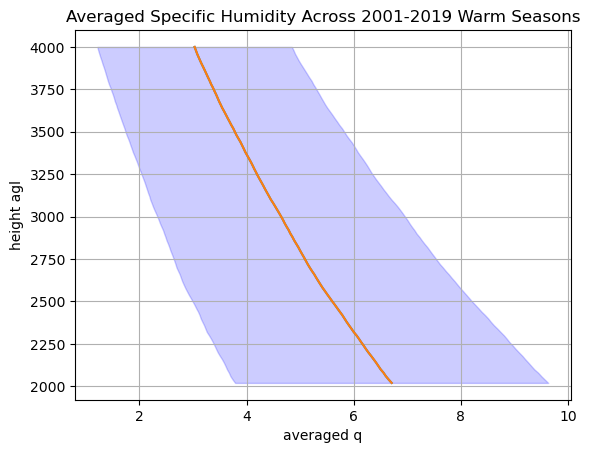

In [15]:
model_v_obs_df['std_plus'] = model_v_obs_df['obs_mean']+model_v_obs_df['obs_std']

model_v_obs_df['std_mins'] = model_v_obs_df['obs_mean']-model_v_obs_df['obs_std']

mm = model_v_obs_df['model_mean']

obm = model_v_obs_df['obs_mean']

mstd = model_v_obs_df['model_std']

obstd = model_v_obs_df['obs_std']

h = model_v_obs_df['height']

fillp = model_v_obs_df['std_plus']

fillm = model_v_obs_df['std_mins']

plt.plot(obm,h)
plt.plot(mm,h)
plt.fill_betweenx(h,fillm,fillp,alpha=0.2,color='blue')
plt.xlabel('averaged q')
plt.ylabel('height agl')
plt.title('Averaged Specific Humidity Across 2001-2019 Warm Seasons')
plt.grid(True)
plt.show()

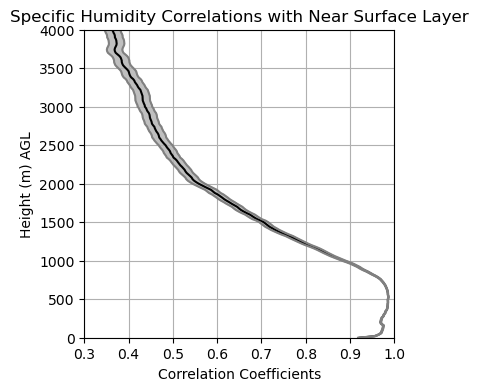

In [16]:
correlations = q_corr_df.corrwith(near_surface_layer)

column_names = correlations.index

ses = []

sqrt_num_rows = np.sqrt(df.shape[0])

for i in correlations.index:
    
    se = (1 - (correlations[i]**2))/sqrt_num_rows
    
    ses.append(se)

plt.figure(figsize=(4, 4))

plt.plot(correlations, column_names, color='black')

plt.plot(correlations + ses, column_names, color='grey')

plt.plot(correlations - ses, column_names, color='grey')

plt.fill_betweenx(column_names, correlations - ses, correlations + ses, color='grey', alpha=0.5, label='Error Bars')


plt.xlabel('Correlation Coefficients')
plt.ylabel('Height (m) AGL')
plt.ylim(0,4000)
plt.xticks([0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
plt.xlim(0.3,1.0)
plt.title('Specific Humidity Correlations with Near Surface Layer')
plt.grid(True)

plt.show()

In [19]:
%run /home/annierosen16/func.ipynb

df["blt"]=""

df["Blc"]=""

df["Br"]=""

errors=0

for index in range(df.shape[0]):
    
    try: 

        row = df.iloc[index,:]

        alt = row['interp_alt'][0:201]

        p = row['interp_pres'][0:201]

        t = row['interp_temp'][0:201]

        dp = row['interp_dp'][0:201]

        qlc = np.array(row['q_fit'])

        qr = np.array(row['q_obs'][0:201])

        b_qr = cal_buoyancy(t_profile = t,         
                                h_profile = qr,         
                                p_profile = p,        
                                alt_profile = alt,
                                entrain_opt = 2
                                )

        b_qlc = cal_buoyancy(t_profile = t,         
                            h_profile = qlc,         
                            p_profile = p,        
                            alt_profile = alt,
                            entrain_opt = 2 
                            )
        pprof_qr = (b_qr.tp)*units.degK

        pprof_qlc = (b_qlc.tp)*units.degK
        
        #i believe problem in final blt calculation is in here somewhere, related to units when i integrate

        t = row['interp_temp'][0:201]*units.degC

        t = t.to(units.degK)

        y_qr = pprof_qr - t

        y_qlc = pprof_qlc - t
        
        pres_100 = p[0]-100

        pres_300 = p[0]-300

        pres_mask = (p >= pres_300) & (p <= pres_100)

        altmask = (alt >= 2000) & (alt <= 4000)
        
#         x_clipped = p[pres_mask]

#         y_clipped_qr = y_qr[pres_mask]

#         y_clipped_qlc = y_qlc[pres_mask]

        x_clipped = p[altmask]

        y_clipped_qr = y_qr[altmask]

        y_clipped_qlc = y_qlc[altmask]
        
        #multiply by kelvin here? check units

        buoyancy_r = (mpconsts.Rd*(np.trapz(y_clipped_qr[::-1], np.log(x_clipped[::-1])))).to(units('J/kg'))

        buoyancy_lc = (mpconsts.Rd*(np.trapz(y_clipped_qlc[::-1], np.log(x_clipped[::-1])))).to(units('J/kg'))

        blt = buoyancy_r - buoyancy_lc

        df["blt"][index] = blt.magnitude

        df["Blc"][index] = buoyancy_lc.magnitude
        
        df["Br"][index] = buoyancy_r.magnitude

        print(index, blt.magnitude, buoyancy_lc.magnitude, buoyancy_r.magnitude)
    
    except Exception as e:
        
        errors+=1
        
        print(e)
    

/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a fut

0 6.333258159022989 -175.0402909908195 -168.7070328317965


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1 -5.758824827651722 -309.8677878304393 -315.626612658091
2 7.431794053810762 -197.9813997096956 -190.54960565588485


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


3 3.863177905857981 -107.39074981063419 -103.52757190477621


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

4 2.6012779089376608 -112.1637710838369 -109.56249317489925
5 -10.549165566825678 -196.6832315884023 -207.23239715522797


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


6 13.621559658695176 -86.80139692114521 -73.17983726245004


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

7 13.08789897458891 -92.2744298198736 -79.1865308452847
8 13.035435544172003 -233.15598830648702 -220.12055276231501


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

9 -6.5225781834631675 -257.0500851454939 -263.57266332895705
10 2.611599929464319 -175.8610268901896 -173.2494269607253


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

11 0.8850085135920267 -129.14596778432457 -128.26095927073254
12 -0.0709450964893108 -147.9210954880733 -147.9920405845626


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

13 -0.3083191274074011 -89.87646208262952 -90.18478121003692
14 -8.801308749078117 -160.5884624109211 -169.3897711599992


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

15 3.172683063452382 -321.3018807210806 -318.1291976576282
16 5.070986281055667 -189.21044541579704 -184.13945913474137


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


17 -10.979796272324364 -214.022882086382 -225.00267835870636


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


18 6.243528719784969 -62.403195641858616 -56.15966692207365


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

19 11.144657260186221 -196.83596506959495 -185.69130780940873
20 5.524726072744954 -307.1380540757441 -301.61332800299914


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


21 11.297036606581315 -261.42531634246006 -250.12827973587875


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

22 -17.396590706289516 -199.19368811831816 -216.59027882460768
23 -10.492959777745398 -295.01307381418593 -305.5060335919313


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


24 -6.260806344993995 -172.5845869199153 -178.8453932649093
25 4.7443238668052174 -131.71179192920127 -126.96746806239605


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

26 3.3117855313255546 -84.78817104764734 -81.47638551632178


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


27 2.672753707625219 -181.88555833364464 -179.21280462601942


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


28 -21.685224786226854 -333.7113280025094 -355.39655278873624


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

29 -24.61081764472749 -302.1332294478156 -326.7440470925431
30 -0.5142720662134721 -46.61080181061811 -47.125073876831586


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


31 -0.28483234054255036 -148.57627036469026 -148.8611027052328


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


32 1.7135085088338542 -189.95081375147853 -188.23730524264468


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

33 -5.3025766452593075 -404.96767632310167 -410.270252968361
34 -11.84168953301321 -367.322288360218 -379.1639778932312


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

35 -6.093970184417117 -535.304142317742 -541.3981125021592
36 -14.13530780434553 -569.9050324321174 -584.040340236463


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

37 3.797722858588827 -275.70276333314615 -271.9050404745573
38 -11.82815990535164 -424.9588744794558 -436.78703438480744


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

39 -10.145197421999598 -253.99255823029486 -264.13775565229446
40 8.032573189918594 -188.66761665268487 -180.63504346276628


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


41 7.139720358489569 -205.75618858027687 -198.6164682217873


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

42 2.1651159584463073 -119.98790220666967 -117.82278624822337
43 -3.331203545678534 -280.1935757707527 -283.52477931643125


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

44 -7.558416543618762 -334.10054558023694 -341.6589621238557
45 -5.586479066849137 -190.15132743905664 -195.73780650590578


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


46 -15.197374807997932 -162.76144853103455 -177.95882333903248


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

47 -5.079247556181201 -396.599531845336 -401.6787794015172
48 -15.476351240542158 -679.0346613070571 -694.5110125475993


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


49 -10.956616098196378 -669.7775853230428 -680.7342014212392


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


50 9.463386681719385 -423.80895063094505 -414.34556394922566


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

51 -0.3556834743867512 -509.5198926107849 -509.87557608517164
52 6.0627057744775925 -411.66688372596894 -405.60417795149135


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


53 -12.97399579422057 -425.61808483658007 -438.59208063080064


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


54 -15.309956229742454 -491.5786214041487 -506.88857763389115


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

55 -8.57034934444249 -294.268211577128 -302.8385609215705
56 -11.138664644815037 -291.001281921792 -302.139946566607


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

57 1.1661992115088538 -177.28628100389525 -176.1200817923864
58 -14.392288744831546 -311.74522497696677 -326.1375137217983


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


59 -4.729219560947996 -152.51032028908605 -157.23953985003405


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

60 -8.699062994127956 -154.45899802897813 -163.1580610231061
61 6.45810564126748 -552.3174662575057 -545.8593606162382


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


62 31.228233693713435 -391.0436070594811 -359.81537336576764


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


63 0.7884394375697639 -328.7741144817334 -327.98567504416366


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

64 18.731030056290933 -588.4700596790171 -569.7390296227262
65 -15.651590861727868 -337.0024965511527 -352.6540874128806


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


66 -10.69939300419486 -321.539712604374 -332.2391056085689


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


67 -11.281837726631721 145.6583156794694 134.3764779528377


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


68 -1.3549197483642388 -424.739564910099 -426.0944846584632


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

69 8.478459257045643 -362.5818234851833 -354.10336422813765
70 2.323922461148072 -367.9405991464828 -365.6166766853347


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

71 -5.228028640548075 -286.671229596775 -291.89925823732307
72 -5.07577546449852 -492.1722256157988 -497.24800108029734


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


73 5.633076357581302 -165.1904819947038 -159.55740563712249


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

74 0.4370038149276638 -463.76284305418136 -463.3258392392537
75 -4.284470215325484 -238.59303827021338 -242.87750848553887


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

76 2.6654417966376087 -72.7455431102745 -70.08010131363689
77 -11.008405390803404 -225.0034570594079 -236.0118624502113


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


78 -11.875252447847402 -441.3617116925262 -453.23696414037363


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

79 -7.392947794345957 -463.73860272246606 -471.131550516812
80 -13.37066650940534 -437.7548672897838 -451.12553379918916


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

81 -4.328746091886217 -359.81420002915957 -364.1429461210458
82 14.571035139014363 -26.056122505566695 -11.485087366552332
83 5.209795844563331 -173.4826630027091 -168.27286715814577


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

84 -7.4107694071697665 -464.78516931135954 -472.1959387185293


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


85 -9.861768743163395 -339.6579154443752 -349.5196841875386


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

86 0.9602187940637137 -55.89976928877036 -54.939550494706644
87 -0.48843412559125454 -176.5210300908443 -177.00946421643556


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


88 -7.268843704950655 -288.91118144651404 -296.1800251514647


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

89 6.8449275877730855 -97.18250835506198 -90.3375807672889
90 -0.10195280288121467 -242.42225692074305 -242.52420972362427


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

91 3.674042917424515 -296.52539567677064 -292.8513527593461
92 -6.247129589511104 -209.4082090658242 -215.6553386553353


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


93 -5.517456697681837 -264.47009857269165 -269.9875552703735


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


94 1.2253344531266066 -355.67516508490087 -354.44983063177426


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


95 -12.188801410260453 -454.1976904586764 -466.38649186893684


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

96 2.7495208730628917 -151.98235121482153 -149.23283034175864
97 3.4830395037296 -153.20201157623399 -149.71897207250439


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


98 2.459623559017132 -341.30180972392355 -338.8421861649064


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

99 -17.4015889433266 -354.2235742662332 -371.6251632095598
100 -3.2889345813467514 -162.3179293651036 -165.60686394645035


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


101 -6.4859975311439655 -211.3513733454741 -217.83737087661805


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

102 -12.402747511996722 795.3522124346331 782.9494649226364
103 5.596198021489386 -132.73584790008695 -127.13964987859757


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


104 -5.206785272695612 -225.28429877530326 -230.49108404799887


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

105 5.795344694626664 -223.7073738716218 -217.91202917699513
106 6.1972067829509285 -147.34963550640506 -141.15242872345414


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


107 3.7961698505876313 -140.65488820399543 -136.8587183534078


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


108 -3.9003970738017983 -176.3111779765512 -180.211575050353


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

109 -2.5607573557771275 -158.59740031308021 -161.15815766885734
110 0.6730949650919129 -52.97879274585096 -52.30569778075905


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

111 2.23041735651006 -71.22235481796938 -68.99193746145932
112 -10.46277132096563 -175.91415372930825 -186.37692505027388


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


113 11.077299045873445 -75.09313589231964 -64.01583684644619


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

114 11.721604920385843 -78.2062594017912 -66.48465448140536
115 -0.9900365412645442 -285.8002786507503 -286.7903151920148


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

116 11.43806327030569 -185.5692297214923 -174.1311664511866
117 7.296979952995088 -160.79387547745037 -153.49689552445528


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


118 -12.75000037329633 -212.85014940688433 -225.60014978018066


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

119 -13.574509012981338 -163.30095408921312 -176.87546310219446
120 2.943146497966211 -133.09702455450463 -130.15387805653842


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


121 -7.516465044952639 -181.2297175352532 -188.74618258020584


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

122 -3.7219693990281257 -210.2935832626841 -214.01555266171223
123 8.34138192711768 -144.8508535999622 -136.5094716728445


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


124 7.907268807920332 -235.83056669113188 -227.92329788321155


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

125 14.118186336385008 -191.19570390202082 -177.07751756563582
126 7.96712498032602 -197.48017284869152 -189.5130478683655


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


127 -2.148911953469053 -119.6874631187514 -121.83637507222045


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

128 1.795558406040982 -279.4573693361172 -277.66181093007623
129 -1.02890368816648 -220.19231752590844 -221.22122121407492


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

130 5.607581861494282 -241.20376921781425 -235.59618735631997
131 -2.7749331095346577 -189.9591740613595 -192.73410717089416


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


132 -1.2314051657427285 -317.49605263688306 -318.7274578026258


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


133 -13.043081754055095 -309.8084247163977 -322.8515064704528


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


134 2.107772038881535 -289.6865985708066 -287.5788265319251


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


135 8.475943596938862 -167.37643145233403 -158.90048785539517


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


136 4.904092347179315 -37.62126490887649 -32.717172561697176


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


137 7.779788498197547 -186.16429111180054 -178.384502613603


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

138 -4.279271277518774 -158.74094613830084 -163.02021741581962
139 -3.1220731303612013 -176.51410196420412 -179.63617509456532


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


140 3.731401865993263 -128.60502911891882 -124.87362725292556


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


141 7.815354377013875 -126.23944022275764 -118.42408584574376


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


142 -3.71140799858307 -218.5978734934133 -222.30928149199636


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

143 3.172100571428075 -271.2188971132247 -268.04679654179665
144 20.93139542127659 -174.01594322694504 -153.08454780566845


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


145 0.6032285991468598 -71.09048510674025 -70.48725650759339


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

146 22.785067088135065 -284.62880948021865 -261.8437423920836
147 -10.896083229440933 -549.292828754943 -560.1889119843839


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


148 4.769902972539384 -102.14977988885913 -97.37987691631974


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

149 -4.6858415107332405 -197.65537222849034 -202.34121373922358
150 -6.8843690219569 -340.8812122763563 -347.7655812983132


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


151 -8.852737955253588 -175.26847974143334 -184.12121769668693


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

152 -7.032390198491015 -208.23155255657048 -215.2639427550615
153 8.402034437307094 -245.59987646127882 -237.19784202397173


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


154 15.968065587055264 -203.2857709865512 -187.31770539949594


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


155 8.08767650011248 -155.82475011775125 -147.73707361763877


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

156 15.661403747025076 -317.34368559790573 -301.68228185088066
157 -5.174914802716103 -274.6669059510604 -279.8418207537765


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


158 -4.171173596897233 -337.4615534261309 -341.6327270230281


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

159 0.08436164645939925 -321.21934741160516 -321.13498576514576
160 -5.024026791854681 -215.43651519484243 -220.4605419866971


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


161 -0.7236392647016316 -132.9240972818983 -133.64773654659993


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

162 -6.140978409248419 -281.9807366777862 -288.1217150870346
163 2.368116268511983 -217.50383486852138 -215.1357186000094


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


164 -1.1052667144888062 -100.45591342836786 -101.56118014285667


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

165 4.0760269972860215 -261.0008792022852 -256.9248522049992
166 2.3365920736214605 -172.021620758655 -169.68502868503353


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

167 -3.4709255794253835 -127.70418931532113 -131.1751148947465
168 6.000963756621218 -96.07464320250101 -90.07367944587979


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

169 -8.487357379195942 538.279741213362 529.792383834166
170 -3.509312439590502 -96.49016049400889 -99.99947293359939


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

171 4.591484226433124 -182.23590909236944 -177.64442486593632
172 9.749404616378655 -177.9473213937147 -168.19791677733605


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

173 13.936172941282138 -88.88210263890919 -74.94592969762705
174 14.345112250674987 -234.500874338896 -220.15576208822102


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


175 11.413044233834114 -176.36063883516692 -164.9475946013328


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

176 9.574258711911789 -41.347284445217106 -31.773025733305317
177 9.145477955229708 -81.9526932291223 -72.8072152738926


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


178 -21.678166435323874 -540.903993710736 -562.5821601460599


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

179 -10.351652667337547 -59.726063926779204 -70.07771659411675
180 -2.5791244730145024 -216.1791875857901 -218.7583120588046


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

181 9.156521549968176 -206.36718111914752 -197.21065956917934
182 -6.777142148638177 -283.9288396554335 -290.70598180407166


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


183 -8.591522455440838 -414.6524651577604 -423.2439876132012


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

184 3.1136553891273024 -513.8775785130128 -510.76392312388555
185 -1.3998951713209067 -436.6086233470556 -438.0085185183765


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

186 -6.6911655817447695 -389.97487683374226 -396.666042415487
187 -9.17036215406688 -415.48163676934854 -424.6519989234154


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


188 -16.18705346578895 -299.1190750693853 -315.30612853517425


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

189 -7.7789485217186325 -500.58978868583233 -508.36873720755096
190 2.0737642444171343 -142.43937875184312 -140.365614507426


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


191 -7.761807938402569 -157.43731543714335 -165.19912337554592


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


192 -2.8339646516701578 -305.49633560250595 -308.3303002541761


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

193 -21.665830870407092 -346.4583006109719 -368.124131481379
194 -9.58855032731259 -255.037793784296 -264.6263441116086


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


195 12.553228534519207 -240.8536335386298 -228.3004050041106


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


196 -23.01592478678743 -46.72180585590346 -69.73773064269089


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


197 -5.005178709666723 -157.76370630943103 -162.76888501909775


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

198 -15.157236813919354 -188.49407242152864 -203.651309235448
199 -3.4062850420059476 -294.4600969179087 -297.86638195991463


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


200 -18.803770384891656 -61.55688497928309 -80.36065536417475


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

201 -10.731437841179513 -444.58155867910097 -455.3129965202805
202 -9.003376775317804 -280.6158023463089 -289.6191791216267


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


203 -9.822002942249753 -212.3988060758546 -222.22080901810435


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

204 -6.177115252237286 -344.96418332165035 -351.14129857388764
205 14.291988905708251 -231.56717461797962 -217.27518571227137


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


206 -10.13625093636081 -69.34283048963312 -79.47908142599393


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

207 -6.873302140894829 -60.72248249193539 -67.59578463283022
208 -1.764747988373827 -50.50081240425167 -52.265560392625495


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


209 -1.6251785321300076 -484.53173502800814 -486.15691356013815


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


210 16.20335058575199 -603.7401395399575 -587.5367889542055


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

211 17.672669548257772 -414.2491590707777 -396.5764895225199
212 -6.7486436466006126 -369.0092447406091 -375.75788838720973


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


213 -17.310274037751356 -466.74520776640804 -484.0554818041594


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

214 1.1809052343176063 -354.16374797062434 -352.98284273630674
215 -10.990221477846376 -414.94560740411004 -425.9358288819564


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


216 13.433542366706376 -186.37361388764234 -172.94007152093596


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

217 -1.5294565290492415 -369.2201445475378 -370.74960107658706
218 14.04539051806205 -614.2830061459497 -600.2376156278876


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


219 13.122618120264917 -390.00185178606296 -376.87923366579804


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

220 -5.033935800860377 -313.9559469411334 -318.98988274199377
221 0.021747078226439953 -273.8452839113763 -273.8235368331499


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


222 4.441201918957745 -165.88527771423915 -161.4440757952814


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


223 8.019591289768712 -126.16265291346265 -118.14306162369394


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


224 -9.966930244187438 -325.0461921368668 -335.01312238105425


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

225 -2.391542800533273 -149.85814165350138 -152.24968445403465
226 4.5004327400869215 -152.60691959825468 -148.10648685816776


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


227 5.305361028188344 -195.2873616506145 -189.98200062242617


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

228 -7.414264401411089 -205.44233293081098 -212.85659733222207
229 -3.621624663067223 -100.86221188761102 -104.48383655067825


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


230 -0.8648855730706089 -142.06556090585318 -142.93044647892378


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

231 1.556440359041403 -109.37072366491806 -107.81428330587666
232 6.599001082770954 -107.53717036456825 -100.9381692817973


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

233 4.106832482999266 -162.04454235326332 -157.93770987026406
234 -2.0417673331146204 -237.56474671585676 -239.60651404897138


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

235 -8.110924995885796 -239.4526050160848 -247.56353001197058
236 -8.711653582905058 -292.7136291486022 -301.42528273150725


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


237 5.440128340234935 -155.27732557082078 -149.83719723058584


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


238 -0.6533115701261636 -493.13964994068175 -493.7929615108079


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

239 4.288992764868027 -183.66453752174854 -179.37554475688052
240 3.569202806714088 -145.31621639692807 -141.74701359021398


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


241 -6.259088633627158 -182.7490838476667 -189.00817248129385


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

242 4.879627689160415 -126.52370926195951 -121.6440815727991
243 -9.612257473477769 -255.6651645167405 -265.2774219902183


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


244 -10.410639216157904 -315.33647759974065 -325.74711681589855


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

245 -5.726273714918193 -433.98285641233497 -439.70913012725316
246 -1.7256604694993314 -214.9903255686827 -216.71598603818202


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


247 0.6306687153727353 -179.21863343472543 -178.5879647193527


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

248 -5.415874550428214 -288.49018269423055 -293.90605724465877
249 0.9686419152889698 -189.10332197021313 -188.13468005492416


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


250 0.6258590480292128 -282.4114572990402 -281.785598251011


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


251 -1.267021981655489 -256.22666170575224 -257.4936836874077


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

252 1.029974989014704 -206.5419933565483 -205.51201836753359
253 -5.0961815696391 -387.30765593728904 -392.40383750692814


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


254 -5.364295619992504 -357.85768219733325 -363.22197781732575


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


255 -4.097999554852379 -277.9580444490861 -282.0560440039385


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


256 -0.5010932854008843 -393.0637491933932 -393.5648424787941


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

257 0.5475467288127902 -389.04292770968425 -388.49538098087146
258 15.067126421133707 -370.9404473175475 -355.8733208964138


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


259 12.591739062662299 -195.07270808079272 -182.48096901813042


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

260 4.355015525616437 -198.8377709814454 -194.48275545582896
261 -1.125051534522754 -177.02490477162266 -178.1499563061454


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

262 8.375389149775835 -33.16749942461564 -24.792110274839807
263 2.7062898003841838 -253.11746487016532 -250.41117506978114


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


264 2.160241780697433 -121.1609681877965 -119.00072640709907


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

265 -2.8258558002073073 -219.15365380854553 -221.97950960875283
266 -6.916943200998503 -542.0050410864552 -548.9219842874537


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


267 8.117073068096033 -321.68666125247347 -313.56958818437744


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

268 -2.246164608055949 -220.84593041122992 -223.09209501928586
269 7.395975625230051 -283.90322521063223 -276.5072495854022


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


270 11.79154009434825 -386.046276524853 -374.25473643050475


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

271 -8.137426528387778 -289.4533791260277 -297.5908056544155
272 11.481392994733085 -76.45837252043775 -64.97697952570466


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

273 -1.4412796376622623 -148.93045357898978 -150.37173321665205
274 5.016053467185159 -130.5448719254696 -125.52881845828445


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


275 6.542453058642138 -161.24620065804672 -154.70374759940458


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

276 0.7812524961874487 -304.2634373697028 -303.48218487351534
277 4.099055025603775 -234.695825500695 -230.59677047509123


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


278 0.4967178038198483 -192.00506412349836 -191.5083463196785


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

279 8.765019319627385 -165.2297572129141 -156.46473789328672
280 -4.078918667159286 -228.79660187127334 -232.87552053843262


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

281 10.132927933965576 -125.64114333373567 -115.5082153997701
282 10.2443815681141 -60.55575125309866 -50.31136968498456


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

283 5.3059182320860145 -151.3118704683562 -146.0059522362702
284 9.14747959266029 -142.3755841767799 -133.22810458411962


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


285 12.606264879649572 -90.85045772922895 -78.24419284957938


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

286 6.105479281459537 -226.46008995296347 -220.35461067150393
287 7.6288566274996015 -180.42461840899634 -172.79576178149674


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

288 14.215341527078351 -324.30974558732487 -310.0944040602465
289 2.0562495899957867 -490.91092600947485 -488.85467641947906


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

290 0.1321437315411913 -550.6720759560556 -550.5399322245144
291 -14.996526907212456 -342.8675723910849 -357.86409929829733


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

292 7.495945990490043 -303.69999783321276 -296.2040518427227
293 3.665553302260207 -289.64416549039356 -285.97861218813335


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

294 -6.4123303022076925 -273.99570406896777 -280.40803437117546
295 -10.128988901072375 -422.381738899675 -432.51072780074736


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


296 -8.846291471151005 -268.27146037791636 -277.11775184906736


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


297 -0.9403768205320375 -168.9658694053938 -169.90624622592583
298 8.182607007531828 -133.56756698586332 -125.3849599783315


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

299 12.019589340303924 -267.5710967007612 -255.55150736045726


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

300 -8.526471381964896 -98.00813242722865 -106.53460380919354
301 -1.7388272925778097 -255.66745059308846 -257.40627788566627


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


302 -12.64960649805613 -268.51844451810194 -281.1680510161581


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


303 13.899776567778417 -597.1058166362703 -583.2060400684919


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

304 -0.42935754189886666 -590.4918420720896 -590.9211996139885
305 1.6874987688577363 -112.0525285596466 -110.36502979078887


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

306 -0.8711211557438219 -265.79838858701834 -266.66950974276216
307 -3.0505901517184384 -326.06956773452237 -329.1201578862408


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


308 -4.6050563357702 -342.5715255738501 -347.1765819096203


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

309 18.400490965694075 -555.1739430738552 -536.7734521081611
310 -8.158770712728654 -295.35742411353374 -303.5161948262624


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

311 3.485051858405029 -353.7799592796253 -350.2949074212203
312 5.308181146895919 -242.6499407661004 -237.34175961920448


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

313 20.31905676165394 -416.74569742455435 -396.4266406629004
314 18.445151344779333 -470.37369071992924 -451.9285393751499


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


315 -4.161246093806241 -84.60604646741648 -88.76729256122272


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

316 -5.70451792864684 17.001833083356846 11.297315154710006
317 4.840463488807131 -435.0765863236839 -430.23612283487677


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


318 -3.229433175862823 -399.1290661130931 -402.3584992889559


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

319 -7.38139940137296 -316.5088569228996 -323.89025632427257
320 -19.913422552398004 -284.8753190621664 -304.7887416145644


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


321 -16.87423645940754 -172.84703047945132 -189.72126693885886


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


322 -4.979560109702035 -98.91376440714602 -103.89332451684805


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

323 -9.36161030340594 -151.37686279132805 -160.738473094734
324 -20.23842855196432 -265.7119212444246 -285.95034979638893


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


325 7.191584765360517 -487.6027867460635 -480.41120198070297


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


326 0.45112904180325586 -387.25062490896966 -386.7994958671664


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


327 -17.004708814402363 -264.0899724246887 -281.0946812390911


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

328 -9.334365472425986 -282.9626090903094 -292.2969745627354
329 -11.327526590633795 -353.6920456397518 -365.0195722303856


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


330 -11.392814490099681 -296.4249000473916 -307.81771453749127


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

331 -12.689355504433138 -359.59650275453896 -372.2858582589721
332 -18.647081994606765 -311.90072439642825 -330.547806391035


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

333 -17.818926134586775 -231.04341614450556 -248.86234227909233
334 -19.375468415441986 -191.92523384625568 -211.30070226169767


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


335 -5.063454672686191 -490.8410744024426 -495.9045290751288


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

336 -15.96162349712543 -181.99416883069463 -197.95579232782006
337 0.5412468918416806 -127.13156485975495 -126.59031796791326


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

338 -17.364000768260155 -125.54462334897107 -142.90862411723123
339 -2.8726641924697685 -12.207259888976758 -15.079924081446526


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


340 -7.408483833068715 -152.65708072092065 -160.06556455398936


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


341 -10.0393478353148 -307.26841187845764 -317.30775971377244


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

342 11.86289650203804 -292.69202257481385 -280.8291260727758
343 -3.81047238542169 -179.7106402220687 -183.52111260749038


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


344 -8.638339544054645 -305.2965244741067 -313.93486401816136


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

345 12.780920293046307 -168.51642071702437 -155.73550042397807
346 13.25667077213103 -142.29659828446864 -129.0399275123376


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


347 4.126406333859393 -198.70821384619475 -194.58180751233536


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


348 -25.821537458345944 -133.28969158390348 -159.11122904224942


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

349 -19.483628932478695 -242.6740854716039 -262.1577144040826
350 -1.2151721312763186 -144.95675442540903 -146.17192655668535


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


351 2.390198423010588 -271.4365425297771 -269.0463441067665


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


352 9.85865601982303 -219.9775596726271 -210.11890365280408


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

353 13.584793564157962 -278.85487862753007 -265.2700850633721
354 3.183528625762449 -376.2422223070431 -373.05869368128066


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

355 9.020460338933304 -209.94620384886187 -200.92574350992857
356 -11.914363106218957 -269.20921148336953 -281.1235745895885


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


357 -16.77344958803201 -358.7005078413712 -375.4739574294032


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


358 5.101826847352868 -301.7852649155184 -296.6834380681655


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

359 11.908091170999455 -303.48827374113984 -291.5801825701404
360 0.24662687626644697 -82.33735041152319 -82.09072353525674


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


361 11.307408783615529 -145.03508607787495 -133.72767729425942


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

362 12.197550650846807 -137.59945259598078 -125.40190194513397
363 13.659513200979973 -143.0304455351582 -129.37093233417824


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


364 11.677452854011932 -245.55819668576805 -233.88074383175612


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


365 -0.2692900662215152 -176.04265279782945 -176.31194286405096


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


366 -7.533358258749104 -296.04625301805885 -303.57961127680795


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


367 -2.4076538080146292 -313.83075898321266 -316.2384127912273


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

368 -3.573378167516836 -185.52001497480933 -189.09339314232616
369 -3.7223164113165694 -285.233113795664 -288.95543020698057


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


370 4.423152979140212 -162.51084115410458 -158.08768817496437


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

371 0.8673355320427731 -201.98889623212864 -201.12156070008587
372 10.318122773922084 -306.8078214338555 -296.4896986599334


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


373 -9.571772513035071 -121.4142411214868 -130.98601363452187


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

374 -8.538682021841453 -158.20333337977195 -166.7420154016134
375 -0.35062860194213386 -252.21557684102723 -252.56620544296936


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

376 -5.43913352508946 -242.52974715611663 -247.9688806812061
377 -8.64288779900005 -335.3252450521127 -343.9681328511127


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


378 12.44988617841193 -165.04951966508366 -152.59963348667173


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


379 11.050062576973914 -212.71252659814712 -201.6624640211732


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


380 1.0069185462696737 -317.36057614193504 -316.35365759566537


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


381 -2.6593881815599048 -279.69367165206353 -282.35305983362343


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

382 0.6975111192085706 -236.85711464163558 -236.159603522427
383 -18.3049736999871 -277.26879975770254 -295.57377345768964


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


384 -5.037929902966646 -30.29164818705761 -35.329578090024256


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

385 11.942924151904208 -304.061915456087 -292.11899130418277
386 7.476421569233196 -434.96864175129605 -427.49222018206285


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


387 -15.838808486156324 -450.0289085161736 -465.8677170023299


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


388 -19.817536786764208 -475.91072001651395 -495.72825680327816


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


389 15.404103896510946 -207.62555970322484 -192.2214558067139


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


390 13.349058090236838 -325.94838043721006 -312.5993223469732


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


391 7.076072496011591 -379.31405323855626 -372.23798074254466


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

392 -0.6940198323300137 -209.72199849509332 -210.41601832742333
393 -12.93215748966972 -223.11137168877826 -236.04352917844798


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


394 -17.826949894481913 -287.4953159430219 -305.32226583750383


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


395 -13.06753700096857 -273.02954780017893 -286.0970848011475


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

396 -15.972209967935385 -406.2918209123167 -422.2640308802521
397 24.570496897123746 -320.54056362156035 -295.9700667244366


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


398 23.323734553354313 -296.1223376805871 -272.7986031272328


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


399 15.756318274614813 -198.00108153083337 -182.24476325621856


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


400 1.2713182781351406 -183.69980414163857 -182.42848586350343


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

401 -3.4592545509011643 -201.8344363346911 -205.29369088559227
402 -19.01556432479532 -201.50075154868946 -220.51631587348479


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


403 12.105916102823045 -222.95970822103013 -210.85379211820708


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


404 8.678188391661166 -167.0677388950122 -158.38955050335105


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


405 7.6640534586907165 -107.01554166578738 -99.35148820709666


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


406 17.28015579988687 -416.67613835603464 -399.39598255614777


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


407 2.414274557392332 -409.7905758195872 -407.3763012621949


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


408 -2.4643545025328137 -255.81258212709187 -258.2769366296247


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


409 0.3546097260513079 -185.02375028638895 -184.66914056033764


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


410 -10.959094841244422 -189.8529764110176 -200.81207125226203


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


411 8.037543679134188 -165.42110816576383 -157.38356448662964


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

412 -6.382837759263708 -186.41153103609048 -192.7943687953542
413 6.108766512455929 -201.74240101533647 -195.63363450288054


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


414 4.596778524094248 -286.93528200512856 -282.3385034810343


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

415 -9.598954790277844 -272.7104230668687 -282.30937785714656
416 -3.1271211970150716 -252.51792073973482 -255.6450419367499
417 -2.2156841763988098 -115.52130854579396 -117.73699272219277


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

418 -0.0987052536087134 -93.17107200885539 -93.2697772624641


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


419 3.042794688312412 -104.96677314512357 -101.92397845681116


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

420 -4.654971834467858 -245.41207290970254 -250.0670447441704
421 -7.918345859237547 -294.2514750052979 -302.16982086453544


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


422 -0.15347418277781344 -364.0523294710743 -364.2058036538521


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

423 -9.999521862521988 -536.4572307275042 -546.4567525900262
424 -3.149123071991312 -435.98385672166705 -439.13297979365836


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


425 -13.05287907306058 -400.4091559846738 -413.4620350577344


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


426 7.031514792066162 -159.9368703823879 -152.90535559032173


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

427 -6.292147891379045 -288.5060705510201 -294.79821844239916
428 -11.614048192327857 -220.6468672718572 -232.26091546418505


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

429 4.287053353552665 -269.20990607161855 -264.9228527180659
430 11.021820629514934 -368.68022654780185 -357.6584059182869


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


431 4.238425020928275 -170.86585346289186 -166.6274284419636
432 -11.656406391127575 -196.17421594118647 -207.83062233231405


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

433 0.18592269947518503 -248.71882230439874 -248.53289960492356
434 2.148649902003399 -424.38765256671934 -422.23900266471594


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

435 -2.228254027154037 -258.383039243161 -260.61129327031506
436 -2.021088998188162 -253.70748625939342 -255.72857525758158


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


437 -4.340111457185117 -436.6490036357248 -440.9891150929099


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


438 -8.306574113029853 -315.759590248841 -324.06616436187085


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

439 0.33163251435573216 -166.414437678461 -166.08280516410528
440 -11.353770900946401 -72.46948453385181 -83.82325543479821


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

441 -5.263709393712844 -186.75051254722658 -192.01422194093942
442 7.490315748777107 -98.02947052420919 -90.53915477543208


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


443 7.461882282131285 -165.39094714756342 -157.92906486543214


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

444 13.014328901419404 -99.82396433989977 -86.80963543848037
445 3.6549172638060554 -41.03734567447679 -37.382428410670734


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

446 -4.981011581814869 -231.58023492876944 -236.5612465105843
447 1.035911446490294 15.577269056910088 16.613180503400383


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


448 6.861457043930415 -227.35082141811768 -220.48936437418726


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

449 -11.801767198633115 -243.40868178254678 -255.2104489811799
450 -10.907522088276764 -123.80642009902301 -134.71394218729978


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


451 14.349152884355021 -230.4995175954657 -216.15036471111068


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

452 -13.424803543233317 -58.63005457608737 -72.05485811932068
453 -6.5181418395824835 -145.21549623037004 -151.73363806995252


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


454 -18.828076628708843 -91.54124131670852 -110.36931794541736


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


455 -0.323148808359889 -196.87631343461214 -197.19946224297203


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


456 4.863424716259999 -191.70049735826086 -186.83707264200086


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


457 10.520754442973967 -101.43585693255723 -90.91510248958326


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

458 -4.4533027261865925 -250.189420186197 -254.6427229123836
459 7.247054922069765 -254.50133681778576 -247.254281895716


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


460 8.015476489005351 -204.9646911012813 -196.94921461227594


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


461 -17.469999413961204 -310.3858183515507 -327.8558177655119


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


462 -14.267962634461895 -220.11181062601923 -234.37977326048113


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


463 -7.316118172974129 -103.26569018551733 -110.58180835849146


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


464 -8.466905056490702 -316.24013619854185 -324.70704125503255


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


465 4.34460908311388 -327.42161348355467 -323.0770044004408


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

466 5.187582657675705 -382.58298186746015 -377.39539920978444
467 -0.48970199633370726 -216.76385106530694 -217.25355306164064


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


468 -1.4686065509479818 -219.53858920047654 -221.00719575142452


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


469 12.258642110291134 -383.4239176648455 -371.16527555455434


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

470 13.280573328612888 -222.50661548972866 -209.22604216111577
471 -9.856488225977387 -221.007715706315 -230.86420393229238


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


472 1.9857201057179168 -67.50316862737293 -65.51744852165501


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


473 -18.41970851842649 -239.08519477588067 -257.50490329430716


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

474 5.284225075170127 -81.47480479144048 -76.19057971627035
475 -7.86073696660435 -141.61991656920938 -149.48065353581373


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


476 6.270525055793939 -212.85988872174468 -206.58936366595074


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


477 8.386726258928718 -166.23326442265045 -157.84653816372173


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

478 -18.086123630643215 -115.74618610872855 -133.83230973937177
479 7.150356079904952 -329.94960637770515 -322.7992502978002


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


480 -0.407908009477012 -113.41090999210036 -113.81881800157737


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

481 -0.054200772060482905 -107.67663214828006 -107.73083292034055
482 -14.720016455277687 -127.51619940837858 -142.23621586365627


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


483 1.9512943751032026 -269.3706318927814 -267.4193375176782
484 -4.265219823878937 -152.9729394670277 -157.23815929090662


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

485 2.5318658941469323 -195.0824234955759 -192.55055760142898


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

486 -1.4643598776386995 -113.48472631422942 -114.94908619186812
487 -13.442946269876273 -199.96768566060746 -213.41063193048373


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


488 0.1251812673559698 -328.4149407677707 -328.28975950041473


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

489 18.659884409472085 -240.32364716688795 -221.66376275741587
490 16.806722739857634 -215.0122245555974 -198.20550181573978


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


491 -2.016471121289186 -245.05355958729743 -247.07003070858661


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

492 25.01687039623755 -378.5847982243021 -353.56792782806457
493 5.083664653759342 -323.0661609286292 -317.98249627486985


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


494 1.183070385850499 -308.7822056612551 -307.5991352754046


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

495 -18.545025478342723 -427.3760448327111 -445.9210703110538
496 7.356592879110366 -255.32786752468743 -247.97127464557707


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


497 -7.335042647188402 -246.4705895890302 -253.8056322362186


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


498 6.765453931567578 -168.16043337463788 -161.3949794430703


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

499 2.1812616973003287 -117.09657781337269 -114.91531611607236
500 1.25584749182606 -76.6029658248164 -75.34711833299033


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


501 7.347534454888532 -130.3051361645513 -122.95760170966277


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

502 -0.6465332740075382 -305.4940998972498 -306.1406331712573
503 -6.324138250068074 -359.78896176891516 -366.11310001898323


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


504 2.749779161618278 -249.6345270988708 -246.8847479372525


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


505 -1.3186004889452079 -299.0754387696539 -300.3940392585991


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

506 -0.6354652072005251 -308.1788048814238 -308.8142700886243
507 1.1460012020893373 -305.4198993758238 -304.27389817373444


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


508 -4.624150883307209 -314.4546183121766 -319.0787691954838


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

509 1.3752080135980833 -72.8841689693573 -71.50896095575922
510 -0.44315844166600016 -119.28694626347779 -119.73010470514379


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

511 0.9179974366401211 -256.5028658131686 -255.5848683765285
512 3.897220782332994 -254.57019408350928 -250.67297330117628


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


513 -2.1741996972691595 -180.23965359590932 -182.41385329317848
514 4.31334042309426 -77.66057129746268 -73.34723087436842


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

515 -1.658991093703932 -34.77585367478573 -36.43484476848966


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


516 -11.777636912779542 -160.34629762156558 -172.12393453434512


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


517 -2.113900932596451 -72.3583896678668 -74.47229060046325


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

518 -3.733067757942024 -131.78674215218217 -135.5198099101242
519 -12.789543209146558 -211.71459271341743 -224.504135922564


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


520 -8.95004990911066 -119.38461817565597 -128.33466808476663


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


521 3.6696030098193404 -118.13368670638164 -114.4640836965623


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

522 2.9485187260017085 -240.3349116731044 -237.38639294710268
523 -5.721521449969259 -301.423359053149 -307.14488050311826


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

524 -2.0750210777530924 -260.35873567005183 -262.4337567478049
525 1.8899836837974249 -162.0281605541626 -160.13817687036519


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


526 -13.286530480558724 -279.881169289732 -293.1676997702907


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

527 9.81341129002908 -210.67276784007214 -200.85935655004306
528 22.035372796746458 -290.64872020476696 -268.6133474080205


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


529 -8.316863621513221 -593.4275207851686 -601.7443844066818


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

530 -8.041014054037419 -555.4160641842647 -563.4570782383021
531 -4.309773164301703 -366.2674825398687 -370.5772557041704


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


532 -3.03950623037332 -368.76071479758167 -371.800221027955


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

533 11.980667961202016 -319.8527289170498 -307.87206095584776
534 9.298358250276266 -208.6618439167239 -199.36348566644764


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


535 3.719159200891596 -148.62679192595618 -144.9076327250646


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

536 9.603188118306683 -41.9632594705733 -32.360071352266615
537 8.71175629587404 -170.84227188994015 -162.1305155940661


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

538 3.0807675778789587 -132.1564357522754 -129.07566817439644
539 0.4415052756219211 -238.8675865869103 -238.42608131128839


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


540 -0.2646222746949718 -237.9007030313768 -238.16532530607176


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

541 0.6437242383051966 -386.7083726368635 -386.0646483985583
542 11.662489174936752 -85.24103679116905 -73.5785476162323


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


543 12.45666062231804 -128.5494691502214 -116.09280852790336


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


544 16.345040031594493 -235.55951280966804 -219.21447277807354


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


545 10.07119269480512 -319.95884570784995 -309.8876530130448


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

546 13.250079522810381 -244.70325006487082 -231.45317054206043
547 7.1258010778250025 -118.16436917091491 -111.0385680930899


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


548 10.298253812654906 -139.05361855102333 -128.75536473836843


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

549 1.2439356113270605 -216.29282305017597 -215.0488874388489
550 16.67080657521967 -17.222611227490116 -0.5518046522704432


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


551 24.78228407502482 -174.52327014508288 -149.74098607005806


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

552 12.755883728046769 -152.84513493868056 -140.0892512106338
553 7.326051098824223 -271.0947409705136 -263.7686898716894


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


554 8.425866437103139 -90.7383541044253 -82.31248766732216


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

555 -6.545706196714804 -124.37082151198945 -130.91652770870425
556 17.43044557174703 -133.44935429951713 -116.0189087277701


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

557 -5.491582165628216 -200.74881941140816 -206.24040157703638
558 -14.684400478882011 -77.09611306052092 -91.78051353940293


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


559 -5.719091734924845 -33.797922277118786 -39.51701401204363


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

560 -9.129973497560627 -202.90090179401852 -212.03087529157915
561 3.5659302784187332 -206.95721160254277 -203.39128132412404


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

562 2.787700286800572 -220.8959695147105 -218.10826922790991
563 -1.448168968400033 -57.10972351334759 -58.55789248174762


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


564 4.613349565555765 -115.28041079313918 -110.66706122758342


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

565 9.582143434331684 -97.68177816642721 -88.09963473209552
566 9.159839264965854 -262.84860320772646 -253.6887639427606


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

567 4.712959157603166 -167.22874074520445 -162.51578158760128
568 10.523506304601995 -243.82101656635587 -233.29751026175387


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


569 -0.9569904568362517 -397.83813471519755 -398.7951251720338


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

570 -5.843631524315981 -367.3738994989286 -373.2175310232446
571 -18.34366592460276 -151.48818425463202 -169.83185017923478


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


572 9.288078028781399 -187.10478352728123 -177.81670549849983


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

573 13.773298490556442 -131.63044850279823 -117.85715001224179
574 21.579949858657187 -298.8997284227891 -277.3197785641319


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


575 -9.876130383533791 -435.21328906321463 -445.0894194467484


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

576 -12.503671679050171 -555.0677416602208 -567.571413339271
577 8.344363012698636 -299.7766357221609 -291.43227270946227


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


578 -4.467436242352164 -290.7083070649208 -295.17574330727297


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

579 -26.455089945740667 -384.37892216802106 -410.83401211376173
580 -8.946879493128733 -333.8550036027563 -342.80188309588505


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

581 -9.336508460886535 -413.49747346951943 -422.83398193040597
582 10.186926714438897 -172.48867598209367 -162.30174926765477


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


583 -15.01718001873428 -318.53088176603086 -333.54806178476514


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

584 4.884318978421618 -340.05672024917294 -335.1724012707513
585 -9.34231296705616 -636.4973115564671 -645.8396245235233


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


586 5.156076914087521 -284.2520875750472 -279.0960106609597


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

587 14.675619970879552 -812.7972797465127 -798.1216597756331
588 8.301135990188754 -415.4174443297161 -407.11630833952734


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


589 -8.656780059824058 -210.8071823013516 -219.46396236117565
590 -18.840295015470332 -163.7893285629715 -182.62962357844182


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

591 4.461859595716959 -257.2848423222409 -252.82298272652392


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


592 6.224416862616067 -332.3166726249622 -326.09225576234616


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


593 6.340004791345223 -300.4526650522984 -294.1126602609532


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

594 3.770076453721515 -229.45776613690865 -225.68768968318713
595 -5.939875396011018 -390.77452253270127 -396.7143979287123


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


596 -4.9042909921622595 -195.74697528267487 -200.65126627483713


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


597 -10.313116536445818 -309.94578484836416 -320.25890138481


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


598 7.514559033474399 -187.37591611441394 -179.86135708093954


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

599 -13.94596662591357 -206.5126049511185 -220.45857157703207
600 1.990896293480148 -210.41719046747386 -208.4262941739937


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


601 -3.2761434271426992 -283.91897295758156 -287.19511638472426


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

602 -0.3543922757056066 -271.63372529854524 -271.98811757425085
603 -5.786325747985587 13.13196379206474 7.345638044079153


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


604 -10.899335019932835 -95.59437996502875 -106.49371498496158


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

605 -10.192503372930332 -136.3220399039957 -146.51454327692602
606 1.7888033938676244 -221.1103849569553 -219.32158156308768


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


607 0.7087143632754191 -146.63461663105977 -145.92590226778435
608 1.1219784379780435 -271.47535592221953 -270.3533774842415


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

609 -4.78119791637539 -322.3279965205326 -327.109194436908


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

610 12.285917262105954 -194.5908122183514 -182.30489495624545
611 -12.193872482763084 -356.54373158408765 -368.73760406685074


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


612 -3.2237414647028686 -293.1744275692688 -296.39816903397167
613 -11.353091245424025 -275.42854754680855 -286.78163879223257


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

614 -19.947258136299354 -172.23441052541475 -192.1816686617141
615 -6.583446219656082 -149.4900773404821 -156.07352356013817


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

616 -7.11611201819656 -232.36639694326092 -239.48250896145748


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


617 6.480536741160407 -102.69978849325861 -96.2192517520982


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

618 -14.14415339096945 -257.7534623087031 -271.89761569967254
619 7.504765352918923 -280.3705846312051 -272.86581927828615


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

620 0.19294407932858348 -306.4703338229083 -306.2773897435797
621 -7.447999046455664 -413.8476967141725 -421.2956957606282


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


622 -9.410486339857584 -230.29593788280187 -239.70642422265945


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

623 -2.026772105603584 -319.1530965031723 -321.1798686087759
624 3.473050606135871 -350.4458646408216 -346.9728140346857


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

625 -2.1514880105892757 -335.6314189654176 -337.78290697600687
626 2.4182512415972326 -164.82790577678705 -162.40965453518982


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

627 6.648268230130782 -357.4365728889693 -350.7883046588385
628 -9.479531402790542 -447.81987521083335 -457.2994066136239


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

629 -10.85555819610795 -540.67749271142 -551.5330509075279
Pressure increases between at least two points in your sounding. Using scipy.signal.medfilt may fix this.
631 -3.135069119392398 -156.06212479758685 -159.19719391697924


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

632 4.306501039332829 -294.0613779841734 -289.7548769448406
633 -1.7604688857251176 -324.7469357697079 -326.507404655433


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


634 -3.309091049034066 -464.2414485696027 -467.5505396186368


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


635 2.324863699963089 -257.9995288018669 -255.67466510190383


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

636 10.133347776287621 -160.58893029253446 -150.45558251624684
637 12.127910856369102 6.7487891637004465 18.87670002006955


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


638 3.2729002892006775 -49.03143567564527 -45.75853538644459


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

639 4.69727162992298 -115.43111943412345 -110.73384780420047
640 -1.7668638931796465 -158.99029480048276 -160.7571586936624


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


641 0.9628248108500088 -239.24225658714624 -238.27943177629624


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

642 6.412011931195281 -209.75465074954428 -203.342638818349
643 0.5113076510864403 -216.03002059479238 -215.51871294370594


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

644 -6.895912019947161 -209.5042284042532 -216.40014042420037
645 -15.294400890012525 -313.1000095630143 -328.3944104530268


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


646 -12.140251485671229 -503.44807581093255 -515.5883272966038


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

647 22.402192502439107 -442.5392316807434 -420.1370391783043
648 20.604299122429666 -295.893769306384 -275.28947018395434


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


649 12.84399115414746 -218.6174837718678 -205.77349261772034


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

650 14.732188881055663 -214.85180420974555 -200.1196153286899
651 8.69406611476171 -279.82302404182315 -271.12895792706144


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

652 -5.699410926148403 -324.4312167613591 -330.1306276875075
653 -14.820948695731715 -185.41185000939072 -200.23279870512243


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

654 8.23874969703212 -93.39011442871343 -85.15136473168131
655 8.265359296265999 -66.76788795274906 -58.502528656483065


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

656 5.56917772631283 -147.38988824885138 -141.82071052253855
657 0.13603817857497802 -205.45974732732523 -205.32370914875025


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


658 5.612491090246522 -149.66460177379787 -144.05211068355135


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

659 4.594728712749884 -270.677000793855 -266.0822720811051
660 -8.992876781606242 -309.8670368706697 -318.85991365227596


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

661 7.922107182092077 -198.61832958876428 -190.6962224066722
662 6.8961384644235295 -250.28112549410318 -243.38498702967965


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


663 10.852070910643306 -141.8663557385834 -131.0142848279401


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

664 9.109421123251849 -150.01771751932458 -140.90829639607273
665 -4.674308811553971 -254.65175992203498 -259.32606873358895


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

666 14.299328275235865 -230.9291561610074 -216.62982788577153
667 2.8437583590027202 -147.01914408630836 -144.17538572730564


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


668 9.338502766784742 -85.63465546678046 -76.29615269999572


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

669 16.099885800203708 -149.18548048400976 -133.08559468380605
670 7.9304284541092045 -163.63517954904754 -155.70475109493833


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

671 12.304031492366207 -113.54354304456038 -101.23951155219417
672 12.128210563381835 -56.87251675883498 -44.74430619545315


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


673 -6.204275293244336 -280.96908833643704 -287.1733636296814


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

674 -0.7176571039314013 -171.36441445746698 -172.08207156139838
675 13.00339487567392 -118.2710885288422 -105.26769365316828


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


676 11.904903816768183 -209.59978137215478 -197.6948775553866


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

677 11.57305902483401 -149.25659412665667 -137.68353510182266
678 8.982198194731438 -132.91229168818558 -123.93009349345414


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


679 12.228111295303648 -229.23107697179032 -217.00296567648667


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

680 15.518876886825012 -153.39288498168884 -137.87400809486383
681 12.959634206171174 -139.19137483949137 -126.2317406333202


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

682 6.20428378991366 -95.29303336905102 -89.08874957913736
683 13.802951210089589 -169.68532049084158 -155.882369280752


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

684 -8.636565418796977 -155.12701641927845 -163.76358183807542
685 1.6312167377968194 -268.8117737001149 -267.18055696231806


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


686 10.361306590332106 -293.6281919132372 -283.26688532290507


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


687 16.47359272937797 -208.25616500684836 -191.7825722774704


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


688 8.31236895618028 -229.98291076704422 -221.67054181086394


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

689 -6.274336819058362 -251.92497166856987 -258.19930848762823
690 -10.470001801617855 -351.83925754405595 -362.3092593456738


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

691 -7.583055106419295 -177.95203265776004 -185.53508776417934
692 -2.4226717322762 -46.49969400177917 -48.92236573405537


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


693 -16.779751906030526 -498.87045941938555 -515.6502113254161


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

694 -8.005232067511258 -416.8497110965794 -424.8549431640907
695 -6.215575065265028 -141.87003489178522 -148.08560995705025


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

696 1.9794517103058524 -458.1687453983592 -456.18929368805334
697 -2.3652860223621133 -304.1349907006346 -306.5002767229967


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


698 -0.9620636787789749 -376.80662440114605 -377.768688079925


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

699 2.048985313578271 -187.88038492634408 -185.8313996127658
700 0.15564066863518633 -163.7267925444131 -163.5711518757779


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

701 0.33132207619932785 -78.00988029067165 -77.67855821447232
702 -4.122723573278023 -227.27100901410748 -231.3937325873855


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


703 -10.979503719864454 -493.1267282460829 -504.10623196594736


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


704 -0.1266634004787761 -321.5974833265384 -321.72414672701717
705 3.379020638174609 -198.71452972446443 -195.33550908628982


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

706 3.0831285077707378 -155.89596405105613 -152.8128355432854


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

707 -13.525455563557102 -106.7532991296475 -120.2787546932046
708 -2.463827914666183 -286.0980371900907 -288.56186510475686


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


709 2.6696371508898267 -174.96073746331865 -172.29110031242882


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


710 2.90930102519971 -90.73022993967535 -87.82092891447564


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

711 4.441428767885441 -94.49176589031927 -90.05033712243383
712 3.8762891670931836 -30.323339651039966 -26.447050483946782


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


713 -15.229867954442739 -137.64450869867298 -152.87437665311572


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

714 -13.044884516350436 -209.90166685705773 -222.94655137340817
715 -1.0321403810712866 -102.57769900948007 -103.60983939055136


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


716 12.493538414452075 -367.0489874671798 -354.55544905272774


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

717 5.2597935701200385 -121.04337917694664 -115.7835856068266
718 5.9038451772813545 -121.19741258635484 -115.29356740907349


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


719 6.219079398795444 -43.014896373466485 -36.79581697467104


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

720 3.3981747473079764 -70.33354541064193 -66.93537066333396
721 -10.496049628857321 -204.52962073330647 -215.0256703621638


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


722 -16.86594242208278 -198.55351273646653 -215.4194551585493


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


723 4.9899281578051955 -424.87293831215374 -419.88301015434854


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

724 2.78503615508248 -241.30315755551288 -238.5181214004304
725 8.483421258187448 -77.94779508962543 -69.46437383143798


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


726 3.988839431030712 -88.67930244684281 -84.6904630158121


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

727 0.41857412254961446 -131.32133218943372 -130.9027580668841
728 -10.872224939840805 -233.06714384906485 -243.93936878890565


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


729 2.8429861054622734 -248.55329861785245 -245.71031251239017


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

730 -4.4230948683761255 -125.89627328570145 -130.31936815407758
731 -1.0102098800115158 -122.23091435648419 -123.24112423649571


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


732 -5.495768120093231 -130.89384099438644 -136.38960911447967


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

733 5.806063292298475 -80.07070687095754 -74.26464357865906
734 -7.540110921999599 -252.19670890043733 -259.7368198224369


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


735 -5.880644448134149 -556.0088810225188 -561.889525470653


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

736 23.320299106241634 -314.7081279456591 -291.38782883941747
737 -0.2904772330277581 -90.66962746165693 -90.96010469468469


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


738 -0.49066985739696634 -79.54926659885558 -80.03993645625255


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


739 4.8850057844570784 -109.43117165343656 -104.54616586897949


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


740 9.680173206898331 -150.83673276446143 -141.1565595575631


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


741 4.185678413575175 -140.3372975497007 -136.15161913612553


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

742 0.3698539285245488 -169.57527140814207 -169.20541747961752
743 6.390975203147349 -113.20845577892271 -106.81748057577536


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


744 -14.474571034858258 -204.81802371153756 -219.29259474639582


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

745 7.885451715304384 -275.6857619565256 -267.8003102412212
746 -5.716204357424402 -215.11225556650294 -220.82845992392734


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


747 5.392893516473464 -179.95921010881827 -174.5663165923448


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

748 -4.075578038223689 -48.69209096316523 -52.76766900138892
749 -1.2487420835240641 -160.6641203368311 -161.91286242035517


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


750 2.019287083143226 -123.81884826669415 -121.79956118355092


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

751 15.915875480444953 -112.94290867722867 -97.02703319678372
752 10.964830456592125 -179.8736332736642 -168.9088028170721


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


753 16.689472368913115 -96.95728292109501 -80.2678105521819


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


754 -9.428013729635524 -213.5396819348776 -222.96769566451312


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

755 11.47119222503386 -191.45642250706322 -179.98523028202936
756 1.4435553489400377 -282.14826308534657 -280.70470773640653


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


757 -6.665247913392534 -236.44733944773327 -243.1125873611258


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

758 2.1295421068990876 -53.010872892951134 -50.88133078605205
759 -2.1099260328837204 -178.50013169990146 -180.61005773278518


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


760 -2.3636940358711627 -176.2033414679731 -178.56703550384427


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

761 -18.004477414299004 -235.00032107910718 -253.00479849340618
762 -5.422706943523565 -71.08719617894256 -76.50990312246613


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

763 -10.758290414998953 -282.2417073594395 -292.99999777443844
764 2.091353471947002 -368.9197453440133 -366.8283918720663


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


765 2.861356668813471 -132.10007676961033 -129.23872010079685


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


766 -7.370713784581369 -111.61861737572559 -118.98933116030696


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

767 -1.9553582537688925 -80.93166315972742 -82.88702141349631
768 1.015406422400801 -84.86824524983408 -83.85283882743327


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


769 -16.70684377092789 -256.46965515600345 -273.17649892693134


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

770 -16.003062728767134 -323.0380636947189 -339.04112642348605
771 -7.333819966061412 -404.65999310012 -411.9938130661814


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

772 -2.1382698113834238 -198.3827274718418 -200.52099728322523
773 2.1115456874327663 -176.90213976166166 -174.7905940742289


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


774 4.828807317313277 -133.19293009602902 -128.36412277871574


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

775 5.3336003059533965 -109.37703517110619 -104.04343486515279
776 3.651581048292087 -267.2299517086772 -263.57837066038513


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


777 -14.976905681315202 -308.77036428692963 -323.74726996824484


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

778 -3.571098249046031 -343.0259232898249 -346.59702153887093
779 6.309660884079676 -145.48064439434054 -139.17098351026087


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


780 18.16393017397087 -118.35242610883857 -100.1884959348677


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

781 8.522559663132661 -42.28341671648462 -33.76085705335196
782 2.3370520042386715 -204.401792584129 -202.06474057989033


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


783 2.6164328202197282 -79.05152064917624 -76.43508782895651


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

784 -11.790362031696418 -263.46616672478007 -275.2565287564765
785 9.00699668573904 -67.02217245417334 -58.015175768434304


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

786 -3.5939612236659855 -262.9619589850048 -266.5559202086708
787 4.557566913836979 -206.67614544236827 -202.1185785285313


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


788 -1.591519641507091 -312.4129501421789 -314.004469783686


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

789 13.34247537516032 -166.0010450121719 -152.65856963701157
790 2.691678360029897 -230.46598456177375 -227.77430620174385


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


791 10.649077530380794 -306.45373324832445 -295.80465571794366


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

792 -4.101661038402085 -350.5453515025696 -354.6470125409717
793 -9.379702611816185 -322.9282933653028 -332.307995977119


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


794 -4.2663953915890716 -280.3206831873012 -284.58707857889027


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

795 -0.3814626835229262 -229.6347207553904 -230.01618343891332
796 -5.751758792052556 -219.14306580868697 -224.89482460073953


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


797 0.6605448340128817 -167.07645770569576 -166.41591287168288


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

798 -5.707142364467501 -167.22089202881622 -172.92803439328372
799 -8.187871928804412 -184.28005964734643 -192.46793157615085


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


800 11.40863166271761 -104.58911329419115 -93.18048163147354


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

801 10.546150684278246 -312.11239341654 -301.56624273226174
802 -3.32936591394116 -265.8507090056419 -269.18007491958303


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


803 -2.8459650265895675 -268.63982411880284 -271.4857891453924


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

804 3.697997124235684 -241.09603588914763 -237.39803876491195
805 -21.105962112374073 -248.98331292384904 -270.0892750362231


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


806 -22.552426413760628 -215.6569476303346 -238.20937404409523


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

807 -12.70794216283204 -182.299185932686 -195.00712809551803
808 -8.799444633846761 -76.90899824973785 -85.70844288358461


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


809 6.095789502337716 -33.5215417790994 -27.425752276761685


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


810 5.605064530518007 -191.94377600543027 -186.33871147491226


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

811 -10.314014232132706 -341.9070846964329 -352.2210989285656
812 -16.983555187959155 -495.79646366446764 -512.7800188524268


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

813 -15.077460542639301 -442.06933857663563 -457.14679911927493
814 -14.798688226481431 -322.98983077451345 -337.7885190009949


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


815 9.411096942057057 -106.73375917347728 -97.32266223142022


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


816 1.1190235412109075 -176.0627166969026 -174.9436931556917


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


817 -7.87537123698678 -208.09422762818798 -215.96959886517476


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

818 12.970616623957383 -122.7739486302996 -109.80333200634222
819 16.583445763054073 -190.26696984379686 -173.68352408074279


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


820 -12.087336719188329 -341.1062697291184 -353.19360644830675


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

821 12.272716891604091 -207.02737505490535 -194.75465816330126
822 -3.928329984435777 -699.5586679233437 -703.4869979077795


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


823 -7.410217808976711 -508.23703777786505 -515.6472555868418


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

824 -16.44181986404243 -363.02642707564036 -379.4682469396828
825 19.347713063094034 -633.3278686058935 -613.9801555427995


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


826 22.131841164881962 -732.1835027151404 -710.0516615502585


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

827 -16.3746123713604 -350.611791625415 -366.9864039967754
828 -17.56283923233275 -264.97754469152045 -282.5403839238532


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

829 0.26018331213593626 -112.05296984621766 -111.79278653408173
830 -8.014644901619477 -153.01104068337688 -161.02568558499635


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


831 6.09485967035468 -259.86874164406754 -253.77388197371286


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


832 10.28944762329337 -216.2632141218655 -205.97376649857213


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


833 -14.668505721354961 -313.73149892184273 -328.4000046431977


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

834 18.146026837358363 -245.11432004599936 -226.968293208641
835 14.862943798385345 -463.2787456660575 -448.41580186767214


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


836 -10.633395119088334 -391.7061352392494 -402.33953035833775


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


837 -19.93079937137108 -73.93997786531892 -93.87077723669


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


838 10.809874932226961 -223.93796738511264 -213.12809245288568


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


839 -8.79872799647643 -393.293282442626 -402.0920104391024


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


840 3.393202709018709 -144.3645873542369 -140.9713846452182


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


841 -21.799605121850618 -161.218358374129 -183.01796349597961


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

842 -11.036869804294497 -539.9161039278436 -550.952973732138
843 -1.8640813785389696 -295.9663749707042 -297.83045634924315


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

844 -9.208562951777964 -148.7770807890551 -157.98564374083307
845 1.5101180743770328 -165.10029855757787 -163.59018048320084


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


846 9.341361054150497 -205.14684239866938 -195.80548134451888


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

847 -14.599308519791975 -309.8768323233834 -324.47614084317536
848 -19.32222913379627 -290.81273203669474 -310.134961170491


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


849 -18.878563482160004 -109.06830955651128 -127.94687303867128


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

850 -11.671263669529708 -548.8335653769482 -560.5048290464779
851 -3.990489408738881 -532.0021309328175 -535.9926203415564


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


852 -25.00716624406175 -354.5586780136122 -379.565844257674


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


853 4.742870084011486 -451.8246020844042 -447.0817320003927


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

854 -12.020653231592348 -203.41583152917715 -215.4364847607695
855 -11.426233240537268 -18.82773030142608 -30.253963541963348


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


856 5.158800612487724 -65.40518410442185 -60.246383491934125


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

857 -4.885234890796056 -121.31523365605688 -126.20046854685293
858 -1.5553432103066598 -330.44155789076217 -331.99690110106883


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


859 20.03897249731625 -480.4479403514075 -460.40896785409126


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


860 11.7254132224827 -419.2855135529155 -407.5601003304328


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

861 -13.776076232716775 -231.44234349864558 -245.21841973136236
862 -12.441859483151632 -283.8532894033146 -296.2951488864662


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


863 11.021856724033341 -260.9554344126801 -249.93357768864678


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


864 -0.9276292379370545 -159.6879388562827 -160.61556809421975


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

865 -15.283844243641482 -163.22004925107308 -178.50389349471456
866 -21.63581613429625 -313.6278200509979 -335.26363618529416


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

867 -10.483045350295413 -402.34354217981013 -412.82658753010554
868 -13.916799101983202 -465.9900045848151 -479.9068036867983


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


869 -11.54335181515296 -304.6036124180525 -316.14696423320544


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


870 -9.233782979458454 -344.03761638577623 -353.2713993652347


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

871 5.840332488852141 -252.27337133255003 -246.4330388436979
872 -10.478590791080592 -364.305176377463 -374.7837671685436


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


873 -4.492070657985266 -398.0317416845913 -402.52381234257655


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


874 -16.8085915071145 -398.9995278205103 -415.8081193276248


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


875 -13.143998574812798 -241.81210589716943 -254.95610447198223


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


876 -3.8524575850069596 -327.4463352577125 -331.2987928427195


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

877 -9.727558341130816 -358.0555911195222 -367.783149460653
878 2.7909623593495496 -134.57758905670016 -131.7866266973506


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


879 6.042338119553591 -174.2356688318615 -168.1933307123079


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

880 2.1077250737297675 -192.65536223748083 -190.54763716375106
881 1.458510070593377 -396.0986838484 -394.64017377780664


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


882 7.663554896536709 -195.95965962868297 -188.29610473214626


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


883 3.689556030422011 -152.77524317933825 -149.08568714891624


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

884 -0.09186902535341801 -171.22707709598563 -171.31894612133905
885 7.321903404331636 -178.2620474701714 -170.94014406583977


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


886 2.7178577962664576 -200.5784623345712 -197.86060453830476


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

887 0.9060556260565136 -151.80781043275536 -150.90175480669885
888 1.600648777514273 -63.10430060117727 -61.503651823663


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

889 11.034664991440778 -108.15407737461605 -97.11941238317527
890 13.111788120011653 -178.6300570115736 -165.51826889156195


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


891 5.855450472485813 -143.1218558918239 -137.2664054193381


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


892 11.700106742846003 -143.38879321765316 -131.68868647480716


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

893 2.352649491387922 -242.76289520923297 -240.41024571784504
894 16.88122630674502 -257.4026815440796 -240.52145523733458


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


895 -5.618619953878749 -378.2956156798512 -383.91423563372996


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


896 -9.88713306859546 -147.79807655314292 -157.68520962173838


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


897 10.077768991093237 -129.5797285179505 -119.50195952685728


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

898 7.579856966941151 -195.52798500620145 -187.9481280392603
899 26.66888163264153 -164.24683934752002 -137.5779577148785


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

900 8.370854699573812 -175.72727269692913 -167.35641799735532
901 -5.879364231002853 -223.66963990337976 -229.5490041343826


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


902 6.60699508367378 -181.48064398374302 -174.87364890006924


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


903 7.9483115483917715 -123.83349687645733 -115.88518532806556


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

904 4.9228866821777615 -122.77654067326874 -117.85365399109098
905 0.8995046322829126 -244.25454508503802 -243.3550404527551


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


906 -3.13893496820873 -225.76702841848154 -228.90596338669027


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

907 3.2717233901496456 -207.81613455731267 -204.54441116716302
908 -5.648543683406103 -266.76286668991827 -272.4114103733244


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


909 2.855972972600256 -211.7199044773651 -208.86393150476485


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

910 15.281431812025346 -152.41507585258773 -137.1336440405624
911 14.719916783247925 -291.188442852411 -276.4685260691631


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


912 -20.44637673431265 -453.0688807535733 -473.51525748788595


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

913 -17.531592687360614 -346.16551277077923 -363.69710545813984
914 -4.941116078043933 -309.2110730047655 -314.15218908280946


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


915 -2.5979395747841636 -269.6353841066399 -272.23332368142405


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

916 -1.6574547539501054 -241.11769825326542 -242.77515300721552
917 6.132834411934169 -155.94496152228973 -149.81212711035556


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

918 -7.558220836158455 -319.1989905668113 -326.75721140296974
919 15.027016406859559 -153.6141744953495 -138.58715808848993


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


920 10.341214325465614 -145.5661318388073 -135.2249175133417


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


921 9.112515458856251 -207.4188290703199 -198.30631361146365


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

922 8.830068049269073 -322.99159089509845 -314.1615228458294
923 9.616692471395197 -278.4329750512284 -268.8162825798332


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


924 -8.17349541925745 -311.3468170310454 -319.52031245030287


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

925 -3.006543620601235 -256.62136383866476 -259.627907459266
926 3.0415128264250484 -217.60781918556606 -214.566306359141


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


927 0.46331494365938397 -187.02929052840636 -186.56597558474698


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

928 -3.5158579390737827 -162.35366052890262 -165.8695184679764
929 5.709949984543073 -158.82519220299665 -153.11524221845357


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


930 7.178608974918333 -120.67882419669701 -113.50021522177867


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


931 7.782646610272877 -272.9727559570582 -265.19010934678533


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

932 8.63079245229929 -171.45631647457157 -162.82552402227228
933 -2.1735463885333104 -195.25163711059048 -197.4251834991238


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


934 13.55092899081177 -122.97837372891537 -109.4274447381036


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

935 6.4021407686546326 -122.72111433360153 -116.3189735649469
936 11.931428474382585 -385.50592589611597 -373.5744974217334


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


937 -6.332319770444258 -338.0149163857652 -344.3472361562095


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

938 -0.7084484744780752 -138.90385133284573 -139.6122998073238
939 -1.4565217512464983 -208.30949628682762 -209.76601803807412


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

940 12.769765307751065 -65.20606779097504 -52.436302483223976
941 2.8857838557753297 -112.98160833945538 -110.09582448368005


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


942 0.9302513218848247 -103.02980850808356 -102.09955718619874


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

943 -11.368474460708683 -280.194503557308 -291.5629780180167
944 10.705092048493313 -100.44831034333716 -89.74321829484384


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


945 22.68167826522273 -406.37752918427435 -383.6958509190516


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

946 -0.44390598049847085 -311.52212153029967 -311.96602751079814
947 26.72825333105476 -460.3292557052497 -433.60100237419493


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


948 5.158504912788658 -393.6700805846981 -388.51157567190944


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


949 4.960930982733487 -416.17244881256505 -411.21151782983156


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

950 -1.9707513054779326 -100.30066952354713 -102.27142082902506
951 8.166693568212395 -398.85811419549054 -390.69142062727815


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

952 -11.391265137740106 -257.2633865041089 -268.654651641849
953 12.587027525625814 -128.1529982512939 -115.56597072566808


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


954 8.938408925268163 -128.75659078332254 -119.81818185805437


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

955 19.093584713465702 -301.5917535371528 -282.4981688236871
956 4.472627400801173 -445.9499095651413 -441.4772821643401


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

957 -13.690285634082613 -482.50183595346533 -496.19212158754794
958 -5.029560215619085 -544.7404280491659 -549.769988264785


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


959 -6.840219423124665 -510.9402990788199 -517.7805185019446


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


960 -14.835393665181016 -357.63112203307327 -372.4665156982543


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

961 -8.898756474070552 -189.99937457476662 -198.89813104883717
962 -6.583687464211778 -121.99430038399802 -128.5779878482098


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


963 -3.896397318989301 -213.4102709588392 -217.3066682778285


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

964 -0.6017472985363668 -151.38721648614154 -151.9889637846779
965 5.037745112747487 -80.31788918495566 -75.28014407220817


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


966 -9.889170474840995 -246.97721929318007 -256.86638976802107


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

967 -16.447742474170695 -264.95002352981106 -281.39776600398176
968 -5.739846842590396 -293.1715372276333 -298.9113840702237


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


969 -7.439396762992175 -219.78296557072764 -227.22236233371981


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


970 -4.411536102800369 -264.94567776967915 -269.3572138724795


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


971 -1.0235306424067971 -509.64676887354364 -510.67029951595043


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


972 17.16866860898614 -493.816445386537 -476.64777677755086


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

973 8.99647853930685 -288.84974609305823 -279.8532675537514
974 -1.0103878391120702 -354.63000632978355 -355.6403941688956
975 8.46074066726925 -353.08949618425316 -344.6287555169839


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

976 0.7290299776779534 -213.31946969747918 -212.59043971980122


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

977 -18.793323557686506 -297.2042823338249 -315.9976058915114
978 -0.7273360542486671 -430.1697687018006 -430.89710475604926


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


979 16.338234470737575 -544.9989480355638 -528.6607135648262


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


980 2.8969733926523418 -467.66769776443294 -464.7707243717806


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


981 13.621893488474598 -443.1272343322076 -429.505340843733


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


982 -18.186637461674422 -535.0844797148395 -553.2711171765139


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

983 19.576063190806792 -431.9068809559178 -412.330817765111
984 -9.34470072785166 -271.1122099251777 -280.45691065302935


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

985 -6.296535146281883 -481.19564598132894 -487.4921811276108
986 4.724568544341764 -403.86953091280566 -399.1449623684639


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


987 6.95684987072093 -376.2156476849391 -369.25879781421816


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

988 -8.908958309524223 -503.80965978793495 -512.7186180974592
989 -12.266172330415884 -564.4837277662332 -576.7499000966491


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


990 -19.3425877680005 -421.4736993379567 -440.8162871059572


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

991 -7.136360147628304 -10.184306678589868 -17.320666826218172
992 -0.8159971171841036 -34.65832580225054 -35.47432291943464


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


993 -1.0859777394748278 -73.43558050709267 -74.5215582465675


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

994 0.9705090963460634 -146.42557893145747 -145.4550698351114
995 9.324644614702777 -424.90208817258844 -415.57744355788566


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


996 -18.61160936404184 -386.8289452844569 -405.44055464849873


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

997 -3.2320958923876617 -179.33889363739013 -182.5709895297778
998 0.23968954814816357 -155.2315140033527 -154.99182445520452


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


999 -7.891862827651238 -159.78044642999953 -167.67230925765077


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1000 -4.07940393293444 -52.722873644960295 -56.802277577894735


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1001 10.256535253594379 -90.00773429372641 -79.75119904013204


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1002 6.435906959770392 -218.1390406438696 -211.7031336840992
1003 8.01560118823619 -269.3666006498308 -261.3509994615946


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1004 3.5383177142473983 -273.7465385052042 -270.20822079095683


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1005 -7.211608887442651 -410.04079478260275 -417.2524036700454
1006 -4.9285999482592615 -288.83215808090546 -293.7607580291647


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1007 -19.590107870001134 -334.1069320544607 -353.6970399244618


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1008 -16.602504699721976 -244.72661460813612 -261.3291193078581
1009 -0.21051520170900062 -247.32604763824838 -247.53656283995738


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1010 -6.733140009772455 -225.00353316115 -231.73667317092244


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1011 -2.1284556489057422 -264.6177067578586 -266.74616240676437
1012 14.68616211133741 -421.9428594168451 -407.2566973055077


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1013 -4.310076820100392 -455.3177204658195 -459.6277972859199


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1014 5.048407841825082 -145.13605499758086 -140.08764715575577
1015 11.002027794477726 -246.52534249418838 -235.52331469971065


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1016 -6.7984467650006195 -283.26859557182377 -290.0670423368244
1017 21.68108594691992 -219.01028792363084 -197.32920197671092


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1018 5.1158288666918 -135.75455648864803 -130.63872762195624
1019 2.252626170348549 -110.88733424908328 -108.63470807873473


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1020 -4.298575971257122 -197.50725376563355 -201.80582973689067


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1021 3.1763881570534522 -112.6538797883657 -109.47749163131225


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1022 -3.523427111616769 -144.1450457277395 -147.66847283935627
1023 8.430331973791894 -106.77014545632373 -98.33981348253184


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1024 10.011262737479925 -137.1177392993405 -127.10647656186059


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1025 6.8011674124731485 -170.89350159496442 -164.09233418249127
1026 -15.647669049976457 -389.0379416518654 -404.6856107018419


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1027 8.408932712239334 -197.74317006740182 -189.3342373551625


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1028 -12.348162251620607 -231.62142192433444 -243.96958417595505
1029 9.978552730983836 -333.59792446904424 -323.6193717380604


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1030 4.988547182161142 -358.3366179727414 -353.34807079058027


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1031 1.6588186997757646 -238.29289779977827 -236.6340791000025
1032 9.389741856058862 -222.879297707577 -213.48955585151813


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1033 -7.177934560541246 -421.42586510534466 -428.6037996658859
1034 -4.233292904620839 -292.01147857993834 -296.2447714845592


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1035 15.952560713710227 -163.372115212295 -147.41955449858477


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1036 8.084232748053694 -407.0740496591429 -398.9898169110892


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1037 -6.265136457208655 -455.86543890015975 -462.1305753573684
1038 -1.056031744397501 -332.8602351917265 -333.916266936124


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1039 4.115743419343914 -191.30745037685742 -187.1917069575135
1040 0.8846971194957405 -264.1675611383563 -263.28286401886055


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1041 10.83239910208087 -202.9427301848428 -192.11033108276192


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1042 1.3504103508280991 -224.64166258285172 -223.29125223202362


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1043 12.009510978165792 -324.26288944657165 -312.25337846840586
1044 2.9278579865601557 -254.4557826659428 -251.52792467938264


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1045 7.165873595064113 -301.4178434115163 -294.2519698164522


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1046 18.763367337595923 -105.18149959605901 -86.41813225846309


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1047 -10.188816644660847 -151.1387305020934 -161.32754714675426


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1048 0.9491195748288419 -235.4985546372161 -234.54943506238726
1049 -6.509787185433623 -215.82570787202894 -222.33549505746257


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1050 -16.362913173464506 -374.5089854696009 -390.8718986430654


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1051 3.2231619302756656 -218.12467764739216 -214.9015157171165
1052 -5.702789919667254 -241.6844686138327 -247.38725853349996


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1053 -6.843673434805908 -238.75712873479202 -245.60080216959793


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1054 22.310363416781655 -256.2456214140488 -233.93525799726714


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1055 -0.443590536863141 -88.96944982574853 -89.41304036261167
1056 2.762366418510652 -157.69693793440925 -154.9345715158986


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1057 10.825054248036082 -215.7645911581463 -204.9395369101102


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1058 7.751990284048304 -219.7071914063748 -211.95520112232649
1059 15.074061271699776 -260.31980028699667 -245.2457390152969


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1060 -3.8209762104170295 -273.44529908818873 -277.26627529860576


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1061 -4.378629161333379 -291.5637188119387 -295.9423479732721
1062 1.5691214750817721 -307.37378180072403 -305.80466032564226


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1063 12.955705579188248 -215.32105243193723 -202.36534685274898


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1064 4.402287902506089 -246.33051863368115 -241.92823073117506
1065 -1.174048873703498 -326.3670104719832 -327.5410593456867


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1066 -7.093832787559933 -228.35503904324892 -235.44887183080886


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1067 -2.6601536912426127 -187.1892934511818 -189.84944714242442


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1068 -22.026892835055094 -261.9502163167314 -283.9771091517865
1069 -6.723090381125189 -334.3442295205881 -341.0673199017133


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1070 8.006300152900849 -187.16289055766444 -179.1565904047636


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1071 14.961246185893515 -147.2236136186783 -132.2623674327848
1072 2.9167002328984495 -321.7846504517348 -318.86795021883637
Pressure increases between at least two points in your sounding. Using scipy.signal.medfilt may fix this.


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1074 24.168721883191836 -268.67366924009735 -244.50494735690552


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1075 12.521458200389077 -360.8793309469652 -348.3578727465761


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1076 2.256682549336233 -386.64684189697954 -384.3901593476433
1077 24.356519266853127 -399.55487520553413 -375.198355938681


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1078 27.960836014579286 -415.42173887904136 -387.46090286446207


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1079 13.580818374754188 -308.12065304689924 -294.53983467214505


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1080 9.2307091669432 -219.89694459453563 -210.66623542759243
1081 0.5701530555706142 -174.34426389578198 -173.77411084021136


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1082 2.6780942565092687 -188.67850080184442 -186.00040654533515


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1083 -21.52551383521984 -464.27137642400766 -485.7968902592275


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1084 -5.37477087672562 -362.7942366605515 -368.16900753727714


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1085 -11.093803472733612 -404.89700070242833 -415.99080417516194
1086 16.915975662609014 -426.4494662454368 -409.53349058282777


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1087 18.20766775400591 -342.3006896154705 -324.0930218614646


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1088 5.780844440737269 -580.8526211272705 -575.0717766865332


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1089 -12.677210672745446 -405.78197183686683 -418.4591825096123
1090 -0.4066318071437536 -207.40345892611882 -207.81009073326257


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1091 2.6557750904625266 -75.25411989991294 -72.59834480945041


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1092 7.030433558078485 -112.30064365552553 -105.27021009744705
1093 7.387703006546755 -7.314919652451686 0.07278335409506952


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1094 9.93905496331891 -85.99719827941313 -76.05814331609422


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1095 -5.818885836568256 -268.3817774301309 -274.20066326669917
1096 13.423272691792732 -160.35316517546772 -146.929892483675


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1097 1.4734563594955885 -8.633858697490052 -7.160402337994463


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1098 -5.932296901660038 -199.0963204250383 -205.02861732669834
1099 13.984017772840048 -318.89709743488464 -304.9130796620446


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1100 15.620022044429476 -214.18454260356134 -198.56452055913186


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1101 -17.051088026319178 -191.51103048128772 -208.5621185076069
1102 15.301580066931422 -297.4037188493996 -282.10213878246816


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1103 8.57618848063467 -193.93340867781563 -185.35722019718096


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1104 5.580461165343138 -82.9444503569406 -77.36398919159747
1105 6.510213136478427 -174.04381647343953 -167.5336033369611


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1106 7.213125442584811 -233.13311519754095 -225.91998975495613


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1107 -5.7345280675549475 -357.16936273282766 -362.9038908003826
1108 -0.9789687798503763 -120.319117492145 -121.29808627199537


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1109 -1.8952741098276888 -61.43734795651767 -63.33262206634536


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1110 1.4993101559230126 -356.50642076533205 -355.00711060940904


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1111 -2.1212790466648244 -294.6382459879081 -296.7595250345729


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1112 12.218655408488871 -687.738302254123 -675.5196468456342
1113 4.094731997776762 -609.2699877472178 -605.175255749441


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1114 5.3697788842364105 -148.3606031539539 -142.99082426971748


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1115 -5.2320442455545475 69.72218125483467 64.49013700928012
1116 -5.202328217627322 -1.385903478685449 -6.5882316963127705


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1117 -1.2839450196796633 -510.7279132881082 -512.0118583077879


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1118 -13.516250180949385 -374.83477221271016 -388.35102239365955


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1119 4.028833915711175 -329.7015102572347 -325.6726763415235


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1120 -20.279834332910184 -460.9872369761424 -481.2670713090526
1121 -18.848744091572712 -533.2875095151453 -552.136253606718


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1122 -13.866992411044407 -474.1844055364968 -488.0513979475412


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1123 -2.478764847832906 -352.916374133974 -355.3951389818069


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1124 -6.9002159497905495 -277.32760758854243 -284.227823538333


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1125 -0.9078407429604454 -300.4425016691994 -301.3503424121598


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1126 9.9445493419081 -298.66513559280844 -288.72058625090034


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1127 -2.217610914073589 -257.8405071148393 -260.0581180289129


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1128 -0.8139090800003714 -297.20420296589646 -298.0181120458968


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1129 -16.484874998656323 -357.42699686792923 -373.91187186658556
1130 -16.39146240071213 -253.65390899889596 -270.0453713996081


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1131 3.981031658875793 -229.38863827681004 -225.40760661793425


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1132 -13.017297707282978 -136.12135034155096 -149.13864804883394
1133 -11.803171462429418 -195.34386968752884 -207.14704114995826


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1134 -12.73379363335232 -254.68456275307102 -267.41835638642334


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1135 12.241758038794586 -112.78444412297642 -100.54268608418184
1136 -16.91647751390491 -320.46661971706845 -337.38309723097336


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1137 -2.503650404719764 -159.3432689409576 -161.84691934567738


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1138 0.5757826136322137 -363.0478244582635 -362.4720418446313


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1139 -5.491209123912114 -136.6858641157038 -142.1770732396159


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1140 -4.7356956677577955 -449.91000335298787 -454.64569902074567
1141 10.051567092694313 -487.4319639517678 -477.38039685907347


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1142 3.218064155448417 -470.5230279393259 -467.3049637838775


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1143 -5.868686178932677 -248.69205648415746 -254.56074266309014
1144 21.71190721259859 -283.2257918782619 -261.5138846656633


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1145 13.859438457446345 -434.2315301748141 -420.37209171736777


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1146 -1.6936792090004076 -184.61309542517856 -186.30677463417896
1147 4.01118579723655 -210.19738942538893 -206.18620362815238


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1148 16.454467246325294 -127.85226393723386 -111.39779669090856


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1149 13.118395089625437 -283.54057033048304 -270.4221752408576


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1150 -10.457420144378148 -154.73401879875718 -165.19143894313532
1151 -4.4558443347289085 -295.39426631174473 -299.85011064647364


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1152 -8.86391784014728 -214.81476152945882 -223.6786793696061


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1153 -1.798387223094437 -131.87993828587997 -133.6783255089744
1154 -0.03647176712772193 -138.03235882876467 -138.0688305958924


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1155 -1.798493525376216 -294.93851713023696 -296.7370106556132


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1156 -8.491724677452112 -363.59288135477874 -372.08460603223085
1157 -3.386500482200404 -319.7513979818335 -323.1378984640339


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1158 -1.8585370224590179 -229.99787444115384 -231.85641146361286
1159 -2.1153118011229424 -141.75524804361837 -143.8705598447413


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1160 7.58782252265857 -125.60297878940094 -118.01515626674237


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1161 -11.304576728352231 -400.58287357742273 -411.88745030577496
1162 11.380500546310486 -163.11137429564684 -151.73087374933635


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1163 -18.88836487192043 -340.6685218700143 -359.5568867419347


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1164 8.060735535265565 -195.39102859038812 -187.33029305512255
1165 23.593171145487418 -162.1499162721168 -138.55674512662938


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1166 18.722800479050363 -148.1751914975889 -129.45239101853855


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1167 10.785452256321662 -96.96706564805899 -86.18161339173733


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1168 0.6151530986760747 -90.37112680219892 -89.75597370352284
1169 -1.1124008736463225 -158.28419529372988 -159.3965961673762


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1170 7.828082829013653 -129.97387911209518 -122.14579628308152


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1171 -7.456191567156225 -179.8608466176585 -187.31703818481472
1172 8.037917224847405 -141.86560988496043 -133.82769266011303


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1173 3.5837731895789773 -208.03868309647797 -204.454909906899


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1174 -19.549125717776064 -212.10375337419757 -231.65287909197363


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1175 8.165248450412037 -195.86422340238698 -187.69897495197495
1176 14.230894885936408 -120.6746341194 -106.44373923346359


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1177 13.036384488826656 -165.26782655739333 -152.23144206856668


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1178 -6.66516223979005 -274.8319301701348 -281.49709240992485
1179 -6.174845778037678 -220.17944387560843 -226.3542896536461


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1180 -9.051719423016522 -254.07927667644535 -263.13099609946187


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1181 6.525494196540791 -186.17601078473697 -179.65051658819618
1182 -3.924263137832469 -244.26409706683305 -248.1883602046655


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1183 5.019908593565219 -205.43435263085954 -200.41444403729432


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1184 15.498846212646939 -142.18829831317717 -126.68945210053023
1185 12.57297454102168 -98.95248144085231 -86.37950689983063


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1186 9.11476011632837 -72.11788002470752 -63.00311990837915


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1187 5.890591133157926 -236.38345467316455 -230.49286354000662


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1188 8.318031951431834 -139.45642171421596 -131.13838976278413
1189 9.550237664684644 -111.19986825234723 -101.64963058766259


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1190 8.77728581886305 -292.61922956254165 -283.8419437436786


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1191 5.609283143987284 -215.88689234212535 -210.27760919813807
1192 16.47684038682584 -128.95103574815568 -112.47419536132983


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1193 2.4094584037953553 -197.45805205707612 -195.04859365328076


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1194 -2.0557142885858752 -275.13784771940544 -277.1935620079913
1195 3.044353489635114 -209.950467308618 -206.90611381898287


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1196 5.374202928654029 -281.5190538442732 -276.14485091561914


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1197 -1.7012535194597262 -265.2798686367039 -266.9811221561636
1198 3.3044489331896045 -71.75191227593342 -68.44746334274382


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1199 17.588281950518635 -136.82349411934888 -119.23521216883024


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1200 4.609357671634797 -165.83775672182486 -161.22839905019006
1201 15.027589487312468 -105.08964041349891 -90.06205092618644


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1202 7.514179612233363 -179.81859139700242 -172.30441178476906


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1203 2.5135236250322635 -150.86661266354236 -148.3530890385101


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1204 12.24750584900599 -152.4026758659423 -140.15517001693632
1205 14.587310967857888 -185.37589986601463 -170.78858889815675


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1206 23.379463465344173 -259.6965939483116 -236.31713048296743


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1207 21.236071985964088 -297.72608278369285 -276.49001079772876


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1208 10.006210761807097 -284.75699193597137 -274.7507811741643


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1209 -23.814944183802083 -471.3475510371531 -495.1624952209552


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1210 -20.792972301259965 -376.9277028600535 -397.72067516131347
1211 13.810927537203725 -205.24311519059162 -191.4321876533879


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1212 -12.423023588275925 -225.18418052729368 -237.6072041155696


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1213 -28.11924982568496 -363.3750638339764 -391.4943136596614


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1214 19.891320186335463 -243.52731908736908 -223.63599890103362
1215 21.615632531564188 -243.8384063972696 -222.22277386570542


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1216 -19.15901912109723 -611.2004619103757 -630.3594810314729


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1217 -10.902194780091236 -474.3792290392927 -485.2814238193839
1218 1.5083646873999896 -356.33310257555365 -354.82473788815366


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1219 -20.599926584357718 -260.95343917530283 -281.55336575966055


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1220 7.995355194670594 -96.19189755372688 -88.19654235905628


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1221 5.434393245957267 -141.92315677262062 -136.48876352666335


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1222 7.978272442665883 -90.0399940234904 -82.06172158082451
1223 12.51294531446905 -267.38018439508687 -254.86723908061782


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1224 -12.579871945156583 -511.4279249451913 -524.0077968903479


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1225 -9.388512852029294 -409.5899798195681 -418.9784926715974


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1226 -0.016136429730238433 -453.77143473682617 -453.7875711665564


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1227 12.217019689832853 -342.51432295342187 -330.297303263589
1228 11.250058535867822 -174.51994061769034 -163.26988208182252


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1229 0.9435255946064558 -362.5862495919002 -361.64272399729373
1230 7.826987510332742 -180.21345552918754 -172.3864680188548


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1231 5.646197391813928 -349.20871264451506 -343.56251525270113


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1232 14.04315403956167 -189.43910245111033 -175.39594841154866


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1233 -9.466707313189545 -95.90351438571115 -105.37022169890069


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1234 4.698941216176536 -283.08982376200646 -278.3908825458299
1235 6.6418532670536194 -157.47367826667036 -150.83182499961674


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1236 -13.639980157583807 -481.5080824784343 -495.1480626360181


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1237 -3.6314079119585756 -236.07746157772573 -239.7088694896843


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1238 2.987609714046542 -129.8381224855291 -126.85051277148257


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1239 -5.220837161029863 -264.0115382650281 -269.23237542605796
1240 -0.2701597028801075 -182.215407901766 -182.48556760464612


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1241 14.498674163369827 -224.24982432446822 -209.7511501610984
1242 7.744074109857394 -200.13840219723394 -192.39432808737655


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1243 13.451631932048372 -204.46135047648465 -191.00971854443628
1244 -9.48497370260037 -367.9228536305337 -377.4078273331341


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1245 -8.345676512061857 -242.36653999385607 -250.71221650591792


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1246 -16.562906232876344 -658.8555308991516 -675.418437132028


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1247 -8.599275262473043 -843.0239910296843 -851.6232662921574
1248 -17.00580916143167 -523.5154473203901 -540.5212564818218


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1249 20.915461678646807 -618.0295155337151 -597.1140538550683


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1250 -9.387507341256764 146.58003812645876 137.192530785202
1251 -7.302991212094639 183.64750656979874 176.3445153577041


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1252 -7.497822604499476 -177.83871651370285 -185.33653911820232


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1253 -7.438009468361448 -1.644555510744072 -9.08256497910552
1254 3.0222996828602504 -262.27017481445705 -259.2478751315968


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1255 -9.635118868052416 -386.65201816790494 -396.28713703595736


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1256 -14.825580178301891 -308.9033924042285 -323.7289725825304


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1257 -7.240740825284206 -320.188755647964 -327.4294964732482
1258 7.490360163637092 -120.26793552902544 -112.77757536538834


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1259 -7.8887469565269726 -234.6262883423511 -242.51503529887808


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1260 4.784826310189487 -305.6296604021045 -300.844834091915
1261 -4.274691924178001 -554.4596763202444 -558.7343682444224


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1262 10.96417319648475 -377.78351319116484 -366.8193399946801


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1263 -3.552910785438371 -410.4184439163783 -413.97135470181667


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1264 21.995462445402325 -422.2595007539312 -400.2640383085289
1265 -8.700007659139828 -353.3320058417418 -362.03201350088165


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1266 4.6139659037642105 -305.03863287586785 -300.42466697210364


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1267 -3.25903538124129 -52.017862090051075 -55.276897471292365
1268 -11.540705635686862 -251.58823549117594 -263.1289411268628


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1269 -22.45159737136251 -160.35274290436104 -182.80434027572355


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1270 -25.373469304250875 -209.02940417059682 -234.4028734748477


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1271 -0.49622884040545046 -70.82340773390904 -71.31963657431449


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1272 -12.252211217592901 -506.9372170770674 -519.1894282946603


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1273 -14.616124233660571 -535.1177368926809 -549.7338611263415


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1274 -19.388584041691047 -541.0052367197603 -560.3938207614514
1275 -12.367018624169646 -462.1973783944116 -474.56439701858125


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1276 -1.8410178772380732 -498.7719743312179 -500.612992208456


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1277 -9.444539784111043 -481.4991346090314 -490.94367439314243
1278 11.276921481409317 -162.58018824781539 -151.30326676640607


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1279 -10.372601969005984 -494.30092612356054 -504.6735280925665
1280 -5.813661290495361 -335.4883505616887 -341.3020118521841


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1281 -8.45006318943399 -242.27249951132762 -250.7225627007616


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1282 -10.6902044329467 -257.82000157845283 -268.51020601139953
1283 -0.19795352010731904 -105.45835224725907 -105.65630576736639


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1284 1.7126630256096007 -143.49855044890722 -141.78588742329762
1285 -1.8883332137996263 -334.8910997512084 -336.779432965008


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1286 -6.089056894963562 -332.6168303121159 -338.70588720707946


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1287 -2.1778482807969795 -279.66253350384164 -281.8403817846386


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1288 7.07804153805418 -170.3016559329079 -163.2236143948537
1289 2.99832600671715 -328.41202654539666 -325.4137005386795
1290 -3.6491691291711845 -388.6350472251044 -392.2842163542756


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1291 -6.160968582933947 -454.7298880351561 -460.89085661809
1292 -3.410210051794394 -194.9653242785548 -198.37553433034918


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1293 1.2466659468435637 -293.66583451897077 -292.4191685721272


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1294 -20.41926575933809 -429.38333059002804 -449.8025963493661


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1295 -20.76511563587684 -422.3921382385933 -443.15725387447014
1296 -14.703937989010626 -374.0733366814075 -388.77727467041814


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1297 -9.334728014608515 -368.79396748519514 -378.12869549980365


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1298 2.7550138961996424 -171.13613905119266 -168.38112515499301
1299 8.385499052881187 -295.53336075040903 -287.14786169752784


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1300 -1.0439773773431398 -322.4411796568832 -323.48515703422635
1301 -7.5542848253181205 -436.4266829276789 -443.980967752997


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1302 -16.690457894804126 -548.1769964143358 -564.8674543091399
1303 -10.409811016914205 -464.2385335875835 -474.6483446044977


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1304 2.974615779716544 -154.6955830491089 -151.72096726939236
1305 9.502809898822903 -63.29785782475235 -53.795047925929445


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1306 3.323472806158037 -133.38379534419778 -130.06032253803974


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1307 4.957782578156042 -150.02526289467704 -145.067480316521
1308 -4.217679815864898 -141.3294374169258 -145.5471172327907


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1309 9.021850339025264 -284.9867827560606 -275.96493241703536


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1310 2.199403017733289 -341.77275577851395 -339.57335276078066
1311 -1.9472100512920747 -401.78948856451086 -403.73669861580294


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1312 1.8125769434277572 -323.71358786936497 -321.9010109259372
1313 5.425017850539035 -171.29327631445324 -165.8682584639142


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1314 6.398569271280479 -156.81198557161042 -150.41341630032994
1315 11.467322664044374 -138.690839265762 -127.22351660171763


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1316 13.969984135643585 -226.819023592793 -212.84903945714942


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1317 4.837835673383154 -273.80183804647737 -268.9640023730942
1318 11.066699360616894 -124.71393882568728 -113.64723946507038


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1319 1.0138471289123174 -169.87394596994093 -168.86009884102862
1320 -0.23979159600108346 -210.2210128865793 -210.4608044825804


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1321 2.5025046950842693 -270.83692405737645 -268.3344193622922
1322 -2.450921428459651 -268.3389832219457 -270.78990465040533


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1323 5.99092238739027 -257.25937655968283 -251.26845417229256
1324 10.662892069034399 -110.98580083889263 -100.32290876985823


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1325 10.018400368652635 -131.81087739819878 -121.79247702954615


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1326 9.187018228973258 -73.5006454918292 -64.31362726285595
1327 13.409863032973306 -203.4623470149416 -190.0524839819683


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1328 11.708319952425342 -187.46319474027177 -175.75487478784643
1329 8.246257651578787 -206.9245615749374 -198.6783039233586


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1330 1.8126994909929124 -156.87272641424073 -155.06002692324782
1331 10.718109560599274 -75.62048054133759 -64.90237098073831


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1332 20.943183526815602 -220.63375039543058 -199.69056686861498


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1333 7.299381683487184 -169.5097784293714 -162.21039674588422
1334 6.552838839568338 -74.94694509843886 -68.39410625887052


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1335 1.4547863198125128 -92.66275342646966 -91.20796710665715
1336 -1.9458086245296329 -199.66035033439763 -201.60615895892727


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1337 11.336985949418363 -298.41229603947653 -287.07531009005817


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1338 11.914928171040799 -282.11409828074943 -270.19917010970863


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1339 10.321372512238042 -176.88706448662444 -166.5656919743864


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1340 12.083765223162345 -316.6826508573081 -304.59888563414574
1341 -13.028837860055546 -385.5493380875425 -398.578175947598


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1342 29.575008975732885 -410.11068255418235 -380.53567357844946
1343 3.2952798993784427 -505.86433088568896 -502.5690509863105


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1344 11.076544826856917 -249.1655663002714 -238.08902147341448
1345 3.2138924923214063 -274.9198567540786 -271.7059642617572


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1346 -8.953765467817334 -268.88564943520686 -277.8394149030242
1347 1.3128016894974905 -146.07560068664287 -144.76279899714538


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1348 8.134702709743692 -203.58642681094562 -195.45172410120193


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1349 13.51918389087109 -231.47279541173063 -217.95361152085954
1350 11.770671979025877 -171.70264385952504 -159.93197188049916


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1351 5.354592439171483 -228.99773719932074 -223.64314476014926


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1352 11.110323596584863 -269.1778067525141 -258.0674831559292
1353 8.75658120594909 -197.5404002273592 -188.78381902141012


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1354 16.43611368062807 -268.65563148927595 -252.21951780864788


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1355 11.718928965781824 9.111393879713361 20.830322845495186
1356 2.1439170142567434 -204.56511126581833 -202.4211942515616


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1357 -4.7634746033364195 -508.9825751290668 -513.7460497324032


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1358 -2.5161655768899323 -452.93822317930267 -455.4543887561926
1359 3.731606044012665 -311.48374556408237 -307.7521395200697


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1360 4.931451580243447 -233.4739504634776 -228.54249888323415


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1361 11.571610182793563 -321.2116212072257 -309.6400110244321
1362 8.552224767781922 -348.4119084344614 -339.8596836666795


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1363 3.9165407903135474 -250.0899464779403 -246.17340568762674


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1364 6.977137770025223 -227.66998971519087 -220.69285194516564
1365 2.3628032964730323 -233.99324241142324 -231.6304391149502


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1366 12.342406412680717 -129.88194630991418 -117.53953989723347


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1367 19.403785204889232 -478.79095201215273 -459.3871668072635


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1368 -15.385699723586868 -674.2828052971872 -689.6685050207741
1369 -14.234421509888193 -627.0891124697557 -641.3235339796439


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1370 -12.811525443769142 -558.3820228508947 -571.1935482946639


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1371 4.494220736233217 -312.5888799083457 -308.0946591721125


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1372 -0.04429823999292637 -110.12546074859112 -110.16975898858405


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1373 -6.030498086668445 -267.72403736752784 -273.7545354541963
1374 9.192834369884082 -238.63396658228436 -229.44113221240028


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1375 4.013867046942664 -313.9973922858849 -309.98352523894226


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1376 15.265148372732085 -405.9190094158654 -390.6538610431333


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1377 17.744867978352147 -453.1363294082816 -435.39146142992945
1378 11.53838171221102 -266.9749128478863 -255.43653113567527


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1379 -3.5964903044537095 -271.4869435599093 -275.08343386436303
1380 -0.8746035963048939 -277.61951290417903 -278.4941165004839


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1381 11.126587223567185 -319.5738190417076 -308.44723181814044


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1382 13.061425911316121 -326.9987184980432 -313.9372925867271
1383 -13.748199054436782 -262.1724103750169 -275.9206094294537


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1384 -6.894790319060235 -309.3752873275312 -316.27007764659146


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1385 -0.7234328247082544 -328.49412108540605 -329.2175539101143


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1386 -8.010383784842475 -633.9782973256623 -641.9886811105048


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1387 15.63515466992817 -593.146446521816 -577.5112918518878


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1388 -10.294325078250438 -494.25301444209003 -504.5473395203405
1389 2.1122971099943584 -254.06769587798308 -251.95539876798873


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1390 -3.1013023035648644 -406.1189876268563 -409.2202899304212
1391 -14.763134338379132 -603.6806502019647 -618.4437845403438


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1392 -12.73502701489906 -283.212384581753 -295.94741159665205


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1393 -19.004717764376153 -355.2112803592421 -374.21599812361825


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1394 -23.955540546907628 -288.69186933158244 -312.64740987849007


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1395 -5.31414971457707 -271.16660121710345 -276.4807509316805
1396 -22.795603856797925 -290.6645829899338 -313.46018684673174


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1397 -19.5863420281421 -342.64010643826003 -362.22644846640213


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1398 7.457260454682853 -305.7586080747028 -298.30134762001995
1399 2.9602227087649453 -203.05538362202887 -200.09516091326392


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1400 -7.452082913393923 -80.17224634549176 -87.62432925888568


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1401 -9.22561528585922 -194.07981493944095 -203.30543022530017
1402 -1.1546951417778928 -43.239105300470264 -44.39380044224816


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1403 -0.031825266409825304 -99.4323208859186 -99.46414615232842


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1404 -2.5168267663783226 -42.25391121767093 -44.770737984049255
1405 1.3180505900239954 9.524411041908694 10.84246163193269


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1406 -16.952683067662804 -194.17274017294318 -211.12542324060598
1407 2.8714716136438767 -132.18540068662017 -129.3139290729763


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1408 -4.510919252087348 -212.5359006252375 -217.04681987732485


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1409 -10.083979044770956 -314.9460242965058 -325.03000334127677
1410 -6.798212280401515 -419.25910894773494 -426.05732122813646


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1411 11.304846571199135 -222.70673577245108 -211.40188920125195


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1412 -4.186968287204024 -268.15253727526726 -272.3395055624713
1413 23.24068624666043 -250.23969544211417 -226.99900919545374


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1414 -11.220617905516292 -502.7843146816665 -514.0049325871828


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1415 -16.541091211513503 -377.4465670517359 -393.9876582632494


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1416 -11.059815512126136 -303.1959708169452 -314.2557863290713
1417 -10.858377291590898 -139.15976759703295 -150.01814488862385


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1418 15.903358645754594 -225.30197758168788 -209.39861893593329


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1419 2.061082028416706 -429.8127948942659 -427.7517128658492
1420 3.4041907586406523 -401.7514740567739 -398.3472832981332


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1421 -3.228723606998983 -276.705360330577 -279.93408393757596
1422 7.62606284571163 -232.05135084298007 -224.42528799726844


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1423 -8.508799044335433 -325.92444889035977 -334.4332479346952


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1424 24.003426789545472 -212.72266059545944 -188.71923380591397


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1425 -7.714302525600317 -288.50387886773984 -296.21818139334016
1426 -8.234348243287798 -397.0094383014874 -405.2437865447752


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1427 0.9515065913002445 -369.13676837046717 -368.1852617791669


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1428 -22.733798781690552 -492.05805339032975 -514.7918521720203


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1429 5.267173673947241 -417.07170678254727 -411.8045331086
1430 -6.411866778997307 -310.31715351611604 -316.72902029511334


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1431 16.662265930037478 -188.29854364022967 -171.6362777101922


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1432 -1.796123134462789 -307.97895684834367 -309.77507998280646


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1433 -0.4899366830894962 -204.60677540093803 -205.09671208402753
1434 0.03797904079394243 -138.7904269661948 -138.75244792540084


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1435 -5.331337857034157 -335.38737277331114 -340.7187106303453


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1436 -12.158683031320948 -399.4821939685902 -411.64087699991114
1437 -8.535598281435512 -307.8008428262215 -316.33644110765704


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1438 -9.291749894748023 -332.65928230817184 -341.95103220291986


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1439 2.1965603483694736 -410.41807584853706 -408.2215155001676
1440 -4.140713469048478 -371.58410347995436 -375.72481694900284


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1441 -1.9257943303423417 -396.4158776193906 -398.3416719497329
1442 -2.0314419552749996 -327.9441305944687 -329.9755725497437


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1443 -14.16432444630533 -349.02316193792143 -363.18748638422676


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1444 -5.348216995236328 -308.73837773335 -314.0865947285863
1445 -11.302653667244556 -357.6785104912112 -368.9811641584558


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1446 -4.850991650075571 -269.06759166354635 -273.9185833136219


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1447 -14.176103787998727 -288.4953813947319 -302.67148518273063
1448 12.021979947497002 -104.37013555771571 -92.34815561021871


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1449 15.909182630505143 -102.29835536982621 -86.38917273932107


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1450 -0.03370769808662999 -201.81588194454883 -201.84958964263546
1451 1.2186885224903392 -210.32883673050364 -209.1101482080133


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1452 4.1904746808291975 -162.64965641843378 -158.45918173760458


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1453 10.957571547893167 -75.2560593559425 -64.29848780804933


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1454 17.16626094387246 -163.98306712780263 -146.81680618393017


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1455 11.217414148189206 -107.17063353599252 -95.95321938780332
1456 19.008974444859405 -159.22684047397692 -140.21786602911752


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1457 1.024074087832446 -65.32277225947776 -64.29869817164531


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1458 4.186655674274192 -73.22189354562516 -69.03523787135097


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1459 11.484889500687025 -53.12779933725407 -41.64290983656704
1460 6.22775743731458 -83.95970548472765 -77.73194804741307


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1461 -1.421858449380295 -161.3089356503542 -162.73079409973448


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1462 10.757497420854804 -225.58441701235904 -214.82691959150424


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1463 7.220208447995333 -130.18351074120181 -122.96330229320648
1464 8.045485062346827 -104.77427057310796 -96.72878551076113


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1465 11.795822446350446 -35.114227871016475 -23.31840542466603


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1466 -1.6363373698914074 -212.268213388359 -213.9045507582504
1467 -2.3760552991727195 -250.1622294645464 -252.53828476371913


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1468 -7.277358873480125 -256.35642692700264 -263.63378580048277


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1469 -1.6444779239651552 -213.2775361434285 -214.92201406739366
1470 7.930144660397502 -197.43863467021873 -189.50849000982123


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1471 13.872402425000459 -99.20312968660531 -85.33072726160485


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1472 13.668261422615586 -64.09828145186434 -50.43002002924875


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1473 1.6273969000387183 -80.31390321537901 -78.6865063153403
1474 7.742326576331408 -77.90108086950757 -70.15875429317616


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1475 8.511037143795662 -81.82809454770928 -73.31705740391362
1476 4.012145803507906 -195.6998650771539 -191.687719273646


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1477 4.0277834581158345 -252.1450080904293 -248.11722463231345
1478 -0.3243618846339018 -348.3861037344653 -348.7104656190992


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1479 12.291685821531871 -316.17280273880846 -303.8811169172766


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1480 5.253662219584754 -188.30853885932777 -183.05487663974301


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1481 8.691220435993216 -405.68167775226755 -396.99045731627433


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1482 16.27464206782625 -119.56917579295424 -103.29453372512799
1483 7.200704401040781 -260.7036049709773 -253.50290056993654


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1484 0.2926148400418924 -290.8158829722267 -290.5232681321848


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1485 -8.1253079446617 -423.7139268628149 -431.8392348074766


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1486 12.827956354258447 -498.63779961712385 -485.8098432628654


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1487 0.11710270482421947 -332.515265628824 -332.3981629239998


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1488 -0.6799445131274524 -428.14284414849084 -428.8227886616183


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1489 11.94376263657324 -283.67959438525196 -271.7358317486787
1490 3.710606125450056 -258.73351329239733 -255.02290716694728


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1491 12.22560434620911 -256.39307216654123 -244.16746782033212
1492 19.960721165859695 -449.2445243540051 -429.2838031881454


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1493 3.1349365178302833 -290.4053631780678 -287.2704266602375


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1494 -19.22011241578258 -207.3496198790005 -226.56973229478308


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1495 -3.043332960104692 -335.23022606488786 -338.27355902499255
1496 -6.481139050752091 -162.5181251684289 -168.999264219181


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1497 -0.6576957687787512 -295.0937008555124 -295.75139662429115


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1498 22.98225482938051 -196.4396722275461 -173.4574173981656
1499 -1.7992091334000975 -293.24342070697736 -295.04262984037746


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1500 -23.825029102844496 -291.28823325656634 -315.11326235941084


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1501 -12.56228665907247 -354.1751539622371 -366.7374406213096
1502 -0.9448588086683003 -410.96228155440383 -411.90714036307213


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1503 -1.2837672528291932 -300.09695465481406 -301.38072190764325
1504 19.389314895534113 -156.36694700836108 -136.97763211282697


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1505 -2.8036646458403425 -207.8722114124111 -210.67587605825145


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1506 3.9756798702897385 -105.74452855456143 -101.76884868427169
1507 16.426271503459816 -87.49390572064401 -71.06763421718419


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1508 -1.0987251831207914 -235.58753769494794 -236.68626287806873
1509 12.693924789937967 -223.26465049035087 -210.5707257004129


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1510 -12.368634135566253 -531.2538737304882 -543.6225078660544


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1511 -3.792602822786307 -400.34626404806534 -404.13886687085164
1512 -6.548226072395494 -437.4694931629326 -444.0177192353281


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1513 -2.536259882012928 -405.0962240939038 -407.6324839759167


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1514 8.197553381329499 -264.4237146149353 -256.2261612336058
1515 18.862450780007862 -462.06887778788894 -443.2064270078811


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1516 5.9498155350472075 -377.5712857274778 -371.6214701924306


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1517 -4.353575854337009 -407.95191072233337 -412.3054865766704


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1518 -21.629288319653654 -341.377862230897 -363.00715055055065
1519 1.962208626134327 -176.68957134108632 -174.727362714952


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1520 -6.548118589562705 -314.8028598819047 -321.3509784714674


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1521 -0.20455650280410964 -384.84495202142773 -385.04950852423184


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1522 -1.7390884582445665 -281.90344625213305 -283.6425347103776
1523 3.185235728041391 -375.6100957290403 -372.42486000099893


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1524 1.1457917589560225 -165.795122756669 -164.64933099771298
1525 -6.45747179049539 -299.8667073015396 -306.32417909203497


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1526 1.0373357401751377 -200.1429146404031 -199.10557890022795


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1527 5.425360555953006 -119.60814363861508 -114.18278308266207
1528 3.746519713176184 -170.4727509456423 -166.72623123246612


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1529 -2.860944770665725 -220.82035395270964 -223.68129872337536


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1530 19.445289930736408 -664.2924302462046 -644.8471403154682
1531 -9.009721223426226 254.00330461275843 244.9935833893322


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1532 8.565845447433162 -401.8846554053207 -393.31880995788754
1533 -8.718072182227559 -286.79727873728007 -295.5153509195076


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1534 2.3571359419047155 -29.31575285371583 -26.958616911811113


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1535 9.431309012652434 -147.352991165542 -137.92168215288956
1536 -13.05592078889623 -280.52589435378536 -293.5818151426816


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1537 -2.969701429977917 -118.64381811643614 -121.61351954641405


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1538 15.344568016051795 -159.45513539151966 -144.11056737546787


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1539 4.148957493327487 -257.9893609331141 -253.8404034397866
1540 -0.4426542727194658 -222.29311567887115 -222.7357699515906


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1541 -2.973825934891579 -279.0566776201379 -282.0305035550295


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1542 -1.5828088182157671 -382.98039901334715 -384.5632078315629
1543 -19.375601311369223 -239.00438167961096 -258.3799829909802


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1544 -23.473920816647308 -206.99917601551073 -230.47309683215803


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1545 -0.6091970362274992 -249.9397394539981 -250.5489364902256


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1546 3.033840768753862 -216.52167329388675 -213.4878325251329
1547 0.8116714866088159 -197.47560432679123 -196.6639328401824


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1548 3.1477706543382453 -210.7424230216374 -207.59465236729915
1549 -2.10030600844226 -301.627786078939 -303.72809208738124


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1550 -7.869883397642468 -282.85360060372756 -290.72348400137


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1551 -0.3149860464301355 -235.10550151049452 -235.42048755692466
1552 -13.94440295405741 -261.19190726598504 -275.13631022004245


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1553 -19.918091099594676 -311.2151638621825 -331.1332549617772
1554 -7.418726153128517 -211.42051405704143 -218.83924021016995


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1555 -13.870883057758306 -543.9281214860418 -557.7990045438002


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1556 19.200517458626962 -441.77747222235286 -422.5769547637259
1557 3.1407533202286686 -258.9775606415197 -255.83680732129102


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1558 1.0183773720041813 -309.52348930018934 -308.50511192818516


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1559 -0.5420332405521435 -345.9905103124841 -346.53254355303625


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1560 5.002141730922801 -240.9030768475952 -235.9009351166724
1561 3.945690349605627 -198.69294219773064 -194.74725184812502


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1562 -3.783491514235749 -147.9000907689615 -151.68358228319724


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1563 2.262231029550435 -335.42787288634 -333.1656418567896
1564 -1.2053350301961814 -475.58802579969625 -476.79336082989244


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1565 -3.4160612059370123 -511.962825169343 -515.37888637528
1566 -12.721023865865732 -456.46815319251 -469.1891770583757


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1567 -6.895361716175358 -215.21950705056167 -222.11486876673703


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1568 9.974230692667973 -96.6134324466303 -86.63920175396233
1569 1.7216958315537738 -133.1608861400526 -131.43919030849884


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1570 8.191882462183543 -263.45485640024293 -255.2629739380594


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1571 -13.8641000420983 -139.0535036645004 -152.9176037065987
1572 0.4364036502999653 -105.62853393327605 -105.19213028297608


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1573 -7.530477223163928 -258.0412178786326 -265.57169510179654


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1574 -16.348163255856747 -249.45967489274685 -265.8078381486036
1575 -2.426643557586374 -275.7795070730096 -278.20615063059597


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1576 -4.516072705233057 -256.53682474271693 -261.05289744795


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1577 -18.26836319987308 -417.16897937894015 -435.43734257881323


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1578 -5.045278081362369 -417.0251878594645 -422.07046594082686


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1579 0.7767585642379231 -312.8427835674935 -312.06602500325556


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1580 -5.0839834204816725 -274.1067756699053 -279.19075909038696


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1581 0.43079661587074725 -341.63230716663696 -341.2015105507662


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1582 12.544635287296046 -240.0424011328636 -227.49776584556756
1583 -5.888560227037942 -259.2037910738716 -265.09235130090957


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1584 -8.770792009325078 -133.02728302082616 -141.79807503015124


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1585 8.090529601151301 -6.123082537659924 1.9674470634913777
1586 6.2689477651325145 -18.30422331990891 -12.035275554776396


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1587 5.735115163857653 -29.944180619980397 -24.209065456122744


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1588 17.594991612967107 -163.03671148566394 -145.44171987269684
1589 4.959347435530162 -198.94340327804616 -193.984055842516


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1590 0.542007494110095 -192.65172643527333 -192.10971894116324


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1591 5.635807325991294 -242.34691558530074 -236.71110825930944
1592 11.12928478190696 -169.91861080345498 -158.78932602154802


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1593 9.638608427860305 -160.62909301437423 -150.99048458651393


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1594 12.034110520240873 -130.25616177438002 -118.22205125413915
1595 6.2767785929676165 -108.0693280738173 -101.79254948084969


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1596 6.396853680211834 -87.10897568540612 -80.71212200519429


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1597 11.747161650966303 -11.677182318150617 0.06997933281568602


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1598 3.6468586771818536 -132.82913060798901 -129.18227193080716
1599 1.0080523889338622 -197.6379735629121 -196.62992117397823


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1600 4.757803194319365 -158.3247693138762 -153.56696611955684


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1601 -4.7533628085448925 -231.9130470794798 -236.6664098880247


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1602 -10.167521476990544 -316.07486378783926 -326.2423852648298


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1603 -13.64709344332897 -354.204525025276 -367.85161846860495


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1604 -0.2684807154755049 -309.44831828146937 -309.7167989969449


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1605 16.84832249187386 -225.68423735792123 -208.83591486604737
1606 13.159291095160597 -197.4541810616374 -184.2948899664768


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1607 7.50947102816059 -242.40273964794542 -234.89326861978483
1608 8.331912630400268 -227.30503621642052 -218.97312358602025


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1609 6.681504949209966 -144.13026339545064 -137.44875844624067


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1610 9.349852003068264 -254.7252321121363 -245.37538010906803
1611 2.0547984867712614 -229.04012473973833 -226.98532625296707


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1612 16.65880696422235 -185.03430393487037 -168.37549697064802


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1613 5.56903984754446 -93.43561875649462 -87.86657890895016
1614 7.602626492916983 -199.54986091435637 -191.9472344214394


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1615 14.029811057081673 -208.1927841999921 -194.16297314291043


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1616 12.387198744664971 -216.39741283224322 -204.01021408757825
1617 -6.658640849004712 -343.4594636685847 -350.1181045175894


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1618 -6.696011842415885 -331.4201607284335 -338.11617257084936
1619 2.637796483836624 -78.8936943942958 -76.25589791045918


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1620 -0.7931028144346328 -262.26503144406183 -263.05813425849647
1621 -16.432580448974704 -385.8237121185766 -402.2562925675513


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1622 10.03992651054216 -293.04861615149406 -283.0086896409519
1623 16.208971444173017 -165.66804313875917 -149.45907169458616


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1624 7.536199599908144 -153.19489695718204 -145.6586973572739


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1625 3.851739276270621 -235.29841761498528 -231.44667833871466
1626 -14.653977110229107 -502.8767140962965 -517.5306912065256


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1627 -18.255518674076257 -483.3498000797778 -501.6053187538541


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1628 -16.280169272353874 -444.70633947881123 -460.9865087511651
1629 11.549525874839162 -276.9460854676993 -265.3965595928601


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1630 11.074584727686783 -170.474290700435 -159.39970597274822


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1631 -4.497369504526546 -270.3827904447123 -274.8801599492389
1632 -6.413693236711481 -199.6667722795895 -206.080465516301


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1633 11.685200351524742 -142.85756819278095 -131.1723678412562


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1634 -1.7017612833609803 -104.54829859708539 -106.25005988044637


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1635 3.2122380976764475 -460.22748754787676 -457.0152494502003
1636 4.490458585709632 -296.2689928462213 -291.77853426051166


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1637 -23.40051063864894 -401.41916155077024 -424.8196721894192
1638 7.7934505793915605 -636.4503204332354 -628.6568698538439


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1639 -10.955814717089993 -600.0393417905052 -610.9951565075952
1640 -1.1501083386284625 2.100094714198833 0.9499863755703705


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1641 -8.139305847468847 -172.34241454069362 -180.48172038816247


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1642 6.256190497277544 -138.09411025238313 -131.8379197551056
1643 -1.519165617063834 -362.8942142897804 -364.4133799068442


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1644 -0.15528848558810182 -197.62124848809245 -197.77653697368055
1645 -3.2409348645925604 -210.4091604201364 -213.65009528472896


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1646 -8.908412222442195 -206.82651897168236 -215.73493119412456


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1647 -8.093809648122374 -321.57232949109726 -329.66613913921964


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1648 -13.371192832797583 -58.657570049503086 -72.02876288230067
1649 -2.913167453075175 -299.35400043946464 -302.2671678925398


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1650 2.682052223724199 -102.91872149488404 -100.23666927115984


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1651 -8.24635265376969 -272.3860000132258 -280.6323526669955
1652 5.733980369604183 -279.05359095423705 -273.31961058463287


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1653 -20.99678658658661 -540.0416728442893 -561.038459430876


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1654 -15.605372163461368 -443.2889920068175 -458.8943641702789


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1655 -9.624955994578897 -413.1054961913007 -422.7304521858796
1656 -8.09339247838659 -139.6285215761641 -147.7219140545507


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1657 -0.031575467074119956 -61.15414153614431 -61.18571700321843
1658 3.8628270296953104 -63.312435919587514 -59.449608889892204


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1659 5.804596093549556 -57.730724926402104 -51.92612883285255


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1660 -0.08779955168743214 -30.50622957723523 -30.594029128922664
1661 -0.862748812887034 -77.17228888826853 -78.03503770115556


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1662 2.6352745048347828 -104.39440094428504 -101.75912643945026


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1663 -8.046067861818806 -50.88309551745292 -58.92916337927173


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1664 3.2150558085199634 -205.02634867383549 -201.81129286531552
1665 2.395642370025058 -223.1751937881883 -220.77955141816324


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1666 9.072554837126603 -224.8297179694779 -215.7571631323513


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1667 -10.31923293284865 -460.64129909253927 -470.9605320253879
1668 1.4206624824766436 -416.5261041844005 -415.10544170192384


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1669 0.8599004939254655 -287.9062931658564 -287.04639267193096


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1670 -6.49557040704633 -358.62122473717903 -365.11679514422536
1671 9.10958405985042 -142.421773212984 -133.31218915313357


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1672 -1.1996853851694311 -247.38522112713432 -248.58490651230375


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1673 -6.48873542591852 -183.82101565663825 -190.30975108255677
1674 -4.891100839891578 -312.1675761147624 -317.058676954654


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1675 -9.165459399972349 -282.93944122485925 -292.1049006248316


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1676 -7.0873332518432335 -459.24858672907635 -466.3359199809196
1677 -0.42807297619447127 -210.45492600804948 -210.88299898424395


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1678 -22.142046922895986 -328.39238732594055 -350.53443424883653


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1679 -6.896032756341299 -292.0093187895359 -298.9053515458772


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1680 -16.22887498924507 -281.373506402768 -297.60238139201306
1681 5.687145729061257 -261.67011928375973 -255.98297355469848


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1682 -2.3229913014450148 -92.29304904836138 -94.6160403498064
1683 2.5515630869368238 -89.8241828132711 -87.27261972633427


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1684 5.737867822742487 -162.47630632586527 -156.73843850312278


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1685 12.383121789552092 -164.58683297599828 -152.20371118644618
1686 6.652606223066002 -64.55137775678732 -57.898771533721316


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1687 1.648411210847371 -163.2483501567628 -161.59993894591543


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1688 0.15882600589048224 -33.16743262077153 -33.008606614881046
1689 -13.285020641473693 -349.1384883319107 -362.4235089733844


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1690 -6.40363411287538 -188.3215688198328 -194.72520293270819
1691 -19.264816029635767 -383.9491794105843 -403.21399544022006


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1692 6.119719369604866 -377.4021033931829 -371.28238402357806


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1693 8.783814406174656 -263.79386096836384 -255.0100465621892
1694 14.082430245146611 -318.2483955578941 -304.1659653127475


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1695 6.570460981634824 -236.23153791873156 -229.66107693709674


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1696 11.416661122189936 -120.4137804137894 -108.99711929159946
1697 5.3546634645474 -177.97737430528056 -172.62271084073316


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1698 6.263725095824782 -197.99357174167534 -191.72984664585056
1699 8.661262419419131 -364.4609350925859 -355.79967267316675


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1700 6.130582784133367 -265.2745293922741 -259.1439466081407
1701 20.67180855205521 -306.10599728667586 -285.43418873462065


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1702 7.533980755833539 -194.21859370204155 -186.684612946208


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1703 10.277014878039893 -180.2986145035524 -170.0215996255125
1704 6.389810315403878 -159.20054504922942 -152.81073473382554


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1705 -6.120755567080607 -247.06463827692428 -253.1853938440049


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1706 -15.012240736883314 -460.00653250102874 -475.01877323791206
1707 22.20153154946115 -337.8442352606573 -315.64270371119613


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1708 20.447613979432788 -322.8057249374599 -302.3581109580271


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1709 7.4174955103540015 -519.7759875507389 -512.3584920403849
1710 5.182936150125784 -481.0000934516784 -475.81715730155264


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1711 -8.587780642682219 -366.5655896347303 -375.15337027741253


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1712 -16.94934972882271 -277.27400006589966 -294.22334979472237
1713 -18.41243278492061 -258.93307025571767 -277.3455030406383


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1714 -16.39446499002682 -177.752975818648 -194.14744080867482
1715 1.1143871870534667 -281.0879736472746 -279.97358646022116


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1716 -12.232214235289234 -367.935368037805 -380.16758227309424


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1717 -9.422365392759275 -357.6766618642313 -367.09902725699055
1718 4.822638695445505 -334.0807644546372 -329.25812575919167


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1719 7.540151137627191 -139.59984187509122 -132.05969073746402


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1720 -7.419191764622383 -281.24691206210605 -288.66610382672843
1721 1.176076628975153 -148.95475369692952 -147.77867706795436


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1722 -13.323887778913502 -166.4794816228813 -179.8033694017948
1723 14.531255949714478 -213.63339040310734 -199.10213445339286


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1724 0.4709367023872346 -242.454733513675 -241.98379681128776


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1725 17.874639224880056 -139.09390192789652 -121.21926270301647


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1726 -1.7627635907992953 -247.29893419211652 -249.06169778291581


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1727 10.379906105013646 -210.84550915761977 -200.46560305260613
1728 11.426910947327116 -215.001578084727 -203.57466713739987


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1729 9.343126270369737 -291.81149328437436 -282.4683670140046


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1730 -3.8527987315764562 -138.7190856630739 -142.57188439465037
1731 16.05705742892718 -368.31447283578956 -352.2574154068624


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1732 17.47171643337049 -395.4673636696315 -377.995647236261
1733 16.126096641844043 -246.02331582636307 -229.89721918451903


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1734 9.015617717340376 -170.6359051787686 -161.62028746142823
1735 1.7341918054604548 -154.93107452787106 -153.1968827224106


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1736 5.756084985638239 -182.70756388884757 -176.95147890320933


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1737 3.6893309843166833 -147.39502821967017 -143.70569723535348
1738 -3.4438449110985516 -228.39372446176006 -231.8375693728586


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1739 12.84364661604124 -84.15881174376352 -71.31516512772228


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1740 4.189276998267786 -179.7955839016792 -175.60630690341142
1741 12.971190138857793 -201.60267542231105 -188.63148528345326


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1742 -0.12483560323423148 -230.18873317458062 -230.31356877781485


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1743 -4.286339856329505 -212.46648929128892 -216.75282914761843
1744 2.560557967973949 -174.1487173769622 -171.58815940898825


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1745 -2.505836887037958 -105.60947496295566 -108.11531184999362


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1746 -4.3320886927099025 -203.18368995966458 -207.51577865237448
1747 22.3152786369657 -168.467576573143 -146.1522979361773


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1748 -5.114106108914257 -184.1932064291243 -189.30731253803856
1749 -3.031273906840653 -172.49525092971527 -175.52652483655592


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1750 -12.755604012472247 -388.5427433299532 -401.2983473424255
1751 -3.42018018418122 -321.5600752421001 -324.9802554262813


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1752 -3.6380178402871195 -205.38009291758985 -209.01811075787697


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1753 9.224014618043583 -237.48759658071918 -228.2635819626756
1754 14.845596198675238 -112.21148188833749 -97.36588568966225


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1755 18.50830989721038 -437.71901469085736 -419.210704793647


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1756 -5.526409890992284 -489.36104242877394 -494.8874523197662


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1757 -15.776215524846236 -317.84621273172974 -333.622428256576


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1758 3.723111417473774 -416.2473192759212 -412.5242078584474
1759 24.635425539775497 -559.7345038513087 -535.0990783115332


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1760 -6.018474483564205 -787.4086288692704 -793.4271033528346


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1761 5.94496191970012 -435.7372575614123 -429.7922956417122


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1762 11.376822173681774 -153.8202747618996 -142.44345258821784
1763 5.907372494262688 -399.6367832611515 -393.7294107668888


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1764 -2.3554080386616647 -212.44825563494368 -214.80366367360534


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1765 15.179381327116744 -329.7233996541613 -314.54401832704457
1766 -3.957141892195324 -154.5261825719711 -158.48332446416643


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1767 -0.24573165166773947 -165.63258442851506 -165.8783160801828
1768 16.236302245988497 -448.73235834527077 -432.49605609928227


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1769 0.1899140354772726 -555.9198913930555 -555.7299773575783


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1770 17.445276583357725 -400.7310912033412 -383.28581461998346
1771 23.95747369018426 -314.09246869206123 -290.134995001877


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1772 14.055619780458812 -349.17684530819105 -335.12122552773224


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1773 -21.73876809845717 -363.1260923627864 -384.86486046124355
1774 -13.915613583465614 -215.54832132605185 -229.46393490951746


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1775 -11.814306694943014 -207.94329370858028 -219.7576004035233


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1776 -1.8760212054463068 -244.43342319919827 -246.30944440464458


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1777 7.967701560615126 -151.94062936807188 -143.97292780745676


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1778 1.9484580158146514 -221.32556180655868 -219.37710379074403
1779 6.337620952723995 -185.94558913757737 -179.60796818485338


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1780 -2.866801253262061 -56.37580056160168 -59.24260181486374
1781 11.314969870289929 -267.3227034376608 -256.00773356737085


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1782 18.53023650309811 -274.0616258481875 -255.53138934508937


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1783 15.668362822195093 -363.05989850908344 -347.39153568688835
1784 4.925590528695054 -86.52426932334467 -81.59867879464962


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1785 -16.48655558107823 12.323935566398248 -4.162620014679982


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1786 -4.435727434202619 -88.4014978217175 -92.83722525592012
1787 4.8571848635390324 -147.40769073967613 -142.5505058761371


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1788 -2.3158999063128363 -421.188818639692 -423.5047185460048


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1789 -4.9471080654057005 -324.3152433525914 -329.2623514179971


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1790 6.2354814784840755 -215.16141658083166 -208.92593510234758


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1791 -10.46676554063555 -215.8328399826807 -226.29960552331625
1792 5.604348375729018 -172.0569871029898 -166.4526387272608


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1793 5.4993037824282 -78.29751528592234 -72.79821150349414


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1794 12.822062351693603 -269.99331422519236 -257.17125187349876
1795 2.672031544071899 -313.33106484610727 -310.65903330203537


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1796 18.67182462012363 -165.94350339308087 -147.27167877295724


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1797 2.6389582665226783 -81.68078259598958 -79.0418243294669


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1798 11.312255397961735 -258.4655213501344 -247.15326595217266
1799 3.788498896861512 -155.05503345538466 -151.26653455852315


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1800 -13.675626950067908 -302.93540641882555 -316.61103336889346
1801 0.1975476557799425 -263.6859686167002 -263.4884209609203


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1802 -17.260213535925743 -326.69103779078745 -343.9512513267132


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1803 -20.929750633542028 -477.85779136545494 -498.78754199899697
1804 -4.282255746203646 -410.5033034956847 -414.78555924188834


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1805 -8.138310302001656 -217.65674454594458 -225.79505484794623


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1806 -8.86082966586065 -234.2610951763321 -243.12192484219275
1807 -5.289474666176261 -197.3384598731792 -202.62793453935546


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1808 -2.27872494371465 -252.58918999628833 -254.86791494000298
1809 3.1943732789310815 -126.542145081618 -123.34777180268692


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1810 0.22290520983989381 -284.20397037309965 -283.98106516325976


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1811 1.6953646503681057 -137.08757434358625 -135.39220969321815
1812 5.045078096881468 -113.55588783600356 -108.5108097391221


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1813 12.83156811535568 -142.69105409395695 -129.85948597860127


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1814 4.341450045391724 -93.95482851029081 -89.61337846489909


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1815 22.29247052742204 -434.3121983283494 -412.01972780092734


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1816 21.077913498668238 -388.74398696922856 -367.6660734705603


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1817 12.850592515193739 -185.24846422665385 -172.3978717114601


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1818 16.00509135949538 -29.531065481238894 -13.525974121743511


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1819 4.766003515151596 -258.01797601597303 -253.25197250082144


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1820 -7.881132170955652 -352.16077521335166 -360.0419073843073
1821 -8.606571405089312 -262.68914729776384 -271.29571870285315


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1822 9.867900544676985 -247.26289890633464 -237.39499836165766


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1823 15.0719747839305 -225.42323451688011 -210.35125973294961
1824 -9.511725869614736 -319.28872896887117 -328.8004548384859


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1825 -11.341801598041343 -313.31281622490303 -324.6546178229444


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1826 11.79866124362286 -171.94406104363324 -160.14539980001038


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1827 19.615063962938706 -210.17136586436428 -190.55630190142557


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1828 -5.949669195466782 -250.32068927453562 -256.2703584700024


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1829 -8.915880457871651 -289.916453326976 -298.83233378484766


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1830 8.358093911017733 -217.0426618541867 -208.68456794316896


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1831 -5.577960464039677 -353.40367580393524 -358.9816362679749
1832 -5.349271858583336 -314.79152297562246 -320.1407948342058


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1833 0.02805758519241408 -178.61430200265775 -178.58624441746534


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1834 18.794629057885885 -210.64138677445192 -191.84675771656603


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1835 21.878722357278065 -205.5161272694461 -183.63740491216802


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1836 20.308323057851823 -154.37822844460302 -134.0699053867512


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1837 17.87081743669208 -221.29691715268558 -203.4260997159935
1838 -9.68425554978512 -370.03812174030924 -379.72237729009436


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1839 -8.941571344461636 -321.47770039205784 -330.4192717365195
1840 -4.738457174464941 -261.6559632593383 -266.39442043380325


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1841 13.260623075014308 -178.00667095073823 -164.74604787572392


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1842 16.983681660999054 -242.1917318976766 -225.20805023667754
1843 8.274402666336016 -309.04987369668197 -300.77547103034595


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1844 36.73293779430861 -354.6705526101026 -317.937614815794


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1845 12.71361620585327 -353.20451712265566 -340.4909009168024
1846 -7.981862750162634 -380.68473584396395 -388.6665985941266


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1847 -6.561788228506771 -283.5405505078183 -290.10233873632507


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1848 -6.872051616119933 -81.21254725946906 -88.084598875589
1849 14.458689896032325 -170.5173605452487 -156.05867064921637


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1850 10.828694631544295 -386.68834579316234 -375.85965116161805
1851 -10.754842829340532 -440.7979814724688 -451.5528243018093


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1852 -9.702249944545997 -240.07638045776082 -249.77863040230682
1853 41.40913686163742 -682.6907200992654 -641.281583237628


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1854 28.34585785930244 -609.7317640206571 -581.3859061613547


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1855 22.564739186982933 -468.9387728948354 -446.37403370785245
1856 -11.780068543746921 -179.35908628208094 -191.13915482582786


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1857 -4.263306806306673 -303.7771598636048 -308.0404666699115


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1858 17.13514266980559 -285.9777007349019 -268.8425580650963
1859 -3.79434187840684 -460.4333899544274 -464.22773183283425


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1860 -3.5297556215412556 -216.95347999280102 -220.48323561434228


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1861 6.77031657507186 -243.27667096904196 -236.5063543939701
1862 -0.12180390346730974 -247.81839069048598 -247.9401945939533


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1863 -5.944088336759734 -252.60339526019575 -258.5474835969555


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1864 6.826327434754646 -106.32138174665828 -99.49505431190363
1865 8.97416398202887 -181.78952541407116 -172.8153614320423


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1866 15.454817746036383 -131.350580399357 -115.89576265332062
1867 -20.90749712654778 -173.55728457194834 -194.46478169849613


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1868 -14.842692116326162 -219.67414094350812 -234.51683305983428


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1869 -3.4141704645820994 -220.59324847562095 -224.00741894020305
1870 6.982518455820724 -242.88772734520455 -235.90520888938383


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1871 15.80191022059239 -359.21064533252553 -343.40873511193314


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1872 13.641149241927849 -383.8681362007185 -370.22698695879063
1873 -5.89737958586926 -421.80137611900886 -427.6987557048781


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1874 1.385066884004857 -211.64783495564768 -210.26276807164282


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1875 -1.824873235561654 -280.25671471555444 -282.0815879511161


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1876 -10.645594355620801 -535.9848638395745 -546.6304581951953
1877 9.346627864398329 -158.34465752732683 -148.9980296629285


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1878 24.615021848545226 -58.825640086496115 -34.21061823795089


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1879 14.47957910513422 -121.14172388205738 -106.66214477692316


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1880 9.87879673065548 -134.70125503645463 -124.82245830579915
1881 -9.398961234818103 -359.87643457666314 -369.27539581148125


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1882 -11.817463488250269 -330.15914513867256 -341.9766086269228
1883 12.555197916181612 -244.3912331938074 -231.8360352776258


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1884 16.63096869325335 -321.5412109757689 -304.9102422825155


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1885 -2.0646027669099 -192.2364898850689 -194.3010926519788


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1886 -5.351049438995631 -249.02175363976323 -254.37280307875886
1887 7.144321432317156 -257.3517019219959 -250.20738048967877


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1888 -7.198177587046928 -348.18484017839955 -355.3830177654465


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1889 -16.75555098498404 -29.836495638404877 -46.59204662338892
1890 0.5293075228397583 -199.50585424473462 -198.97654672189486


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1891 -13.504143722599451 -406.0770911463306 -419.58123486893004


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1892 -2.0105425885717523 -168.53096646895546 -170.5415090575272
1893 1.6731423043113978 -202.3951157456864 -200.721973441375


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1894 26.49180038885123 -509.91028350268004 -483.4184831138288


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1895 13.198737469415903 -279.1428118351559 -265.94407436574


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1896 -13.210889317077545 -343.1470629609093 -356.35795227798684


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1897 -0.4009231515290139 -305.31385831887513 -305.71478147040415


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1898 12.21517283194683 -232.41830448638999 -220.20313165444315
1899 -6.563210497355556 -165.30214951583343 -171.865360013189


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1900 1.9530237526026895 -81.77146393758589 -79.8184401849832


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1901 -27.823846145496134 -137.47722212416647 -165.3010682696626
1902 -2.2370248679567766 -105.25462705707442 -107.49165192503119


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1903 -3.5719834643998922 -191.72624735571117 -195.29823082011106


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1904 -5.1210835208297505 -4.172238120375707 -9.293321641205457
1905 5.1868646509587535 -96.38404545174315 -91.1971808007844


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1906 1.416548254355682 -58.35064865750892 -56.93410040315324


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1907 5.518942027259712 -74.37189045826801 -68.8529484310083


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1908 5.6414099614598 -195.7942957256945 -190.1528857642347
1909 5.66981272592745 -49.94947766091351 -44.27966493498606


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1910 -10.532393038295425 -413.2535126352271 -423.7859056735225


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1911 -10.737925179763295 -324.1504516749034 -334.8883768546667
1912 1.3126628625805097 -193.60729339651635 -192.29463053393584


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1913 -2.9477781523164026 -227.68721694233994 -230.63499509465635
1914 11.951689371905516 -116.8582520977787 -104.90656272587319


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1915 -0.6702495337369214 -246.7829613590756 -247.45321089281254


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1916 17.49860309101541 -255.7810952570066 -238.2824921659912
1917 -17.408321004116715 -79.32833834624985 -96.73665935036657


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1918 -3.2244966965094193 -183.32421273728585 -186.54870943379527
1919 1.392494835839642 -202.14464838061804 -200.7521535447784


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1920 5.581476430099201 -177.51172142514898 -171.93024499504978
1921 -7.400116459120113 -381.71752155087034 -389.11763800999046


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1922 12.46904871341556 -156.87107759488498 -144.40202888146942
1923 8.274428649923607 -217.96013884440418 -209.68571019448058


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1924 -1.4081279007605758 -253.30084991399468 -254.70897781475526


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1925 4.884009454332812 -140.10189426566293 -135.21788481133012


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1926 20.808245937069216 -165.40999713018599 -144.60175119311677
1927 7.5467127513611985 -111.54648463512892 -103.99977188376772


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1928 8.38984633203178 -101.32506231091867 -92.93521597888689


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1929 13.556340605895315 -258.8079747093721 -245.2516341034768
1930 -1.1547334169133308 -220.26954631973044 -221.42427973664377


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1931 -14.599616975279531 -216.9773207989584 -231.57693777423793


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1932 -13.98511720309989 -465.1702363223518 -479.1553535254517


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1933 11.735165707196984 -129.71360994085404 -117.97844423365706


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1934 5.677942892684342 -160.43144786240333 -154.753504969719
1935 -4.882516481091841 -509.9620452736602 -514.844561754752


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1936 7.806734519201086 -454.18314731632864 -446.37641279712756


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1937 7.822871135499071 -213.73806936182174 -205.91519822632267


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1938 -5.234681739205911 -188.1151446716668 -193.3498264108727
1939 -3.4528014689685733 -254.0124974675714 -257.46529893653997


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1940 -6.3777879149996295 -228.00124800562836 -234.37903592062798
1941 5.501111619476944 -181.86843443245482 -176.36732281297787


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1942 6.742877064085491 -196.3474353259795 -189.604558261894


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1943 3.377390682533644 -240.972082359663 -237.59469167712936
1944 -3.7944221957782815 -259.7221593807696 -263.5165815765479


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1945 5.798987944382986 -183.1976443614478 -177.3986564170648


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1946 13.743856607218163 -209.1827010025942 -195.43884439537604
1947 3.7405165804666183 -118.14471512714073 -114.40419854667411


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1948 5.638198517999001 -150.78815359421984 -145.14995507622083


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1949 6.545220887837814 -100.11239945340415 -93.56717856556634


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1950 3.452651474836898 -347.0001383327825 -343.5474868579456


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1951 9.60653966661144 -204.0442235304153 -194.43768386380387


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1952 7.908387778644737 -159.32293282267528 -151.41454504403055
1953 13.157552015208722 -148.4146450097715 -135.25709299456278


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1954 8.361998454014781 -176.95925589323406 -168.59725743921928


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1955 7.05157991796861 -181.14487883279017 -174.09329891482156


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1956 13.505864016578386 -262.34701747670107 -248.84115346012268
1957 16.823873436799943 -243.50522777608012 -226.68135433928018


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1958 18.34314362414392 -255.30040979240707 -236.95726616826315


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1959 10.055383710551808 -215.3436522113232 -205.28826850077138
1960 17.25177440692474 -101.61509961217475 -84.36332520525


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1961 19.28920869838318 -41.463860643775604 -22.174651945392423


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1962 16.91213881626598 -146.49039400517512 -129.57825518890914
1963 10.089987099924741 -170.51544424984237 -160.42545714991763


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1964 -12.054183135252629 -280.4903460078679 -292.54452914312054


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1965 3.0318173304452216 -148.4570657778779 -145.42524844743266
1966 12.079505140661752 -132.68486545095362 -120.60536031029187


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1967 -0.27778282866654536 -241.70925725214653 -241.98704008081307


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1968 5.8239239787465635 -231.57389957765602 -225.74997559890946
1969 7.748135283475236 -134.9967252693435 -127.24858998586826


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1970 10.219448642656744 -341.02194933378047 -330.8025006911237


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1971 -13.503363489303297 -493.650857840355 -507.1542213296583
1972 -1.783060207675419 -415.25096096067665 -417.03402116835207


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1973 20.487446801997635 -171.01522340679597 -150.52777660479833
1974 -9.660125487060753 -224.16306967104305 -233.8231951581038


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1975 8.33476163590845 -149.33994826414096 -141.0051866282325


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1976 1.2571170262692704 -148.04253992635196 -146.7854229000827


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1977 11.512232208142237 -70.63809635527626 -59.125864147134024
1978 7.618887458390141 -71.45029039535669 -63.83140293696655


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1979 18.56364733500648 -141.68662877313983 -123.12298143813335


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1980 -2.286611647607373 -108.22939753577667 -110.51600918338404
1981 13.729240459971052 -48.85431420049661 -35.12507374052556


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1982 17.919310900659625 -115.14785870738457 -97.22854780672495


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1983 -16.500779115641194 -379.7987584434841 -396.29953755912527
1984 9.739775167916832 -299.2508180814799 -289.5110429135631


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1985 12.94540920479244 -171.98110174496617 -159.03569254017373


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1986 11.043538949420252 -250.62643985444768 -239.58290090502743


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1987 6.784440513773745 -165.45691903578103 -158.67247852200728
1988 21.602394370603662 -207.43023746017712 -185.82784308957346


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1989 2.4046201599493315 -217.49359434680025 -215.08897418685092


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1990 -11.909903850507419 -270.63541264577736 -282.5453164962848
1991 -15.122348644663617 -209.18589248203713 -224.30824112670075


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1992 2.5099356717131514 -219.95718365553446 -217.4472479838213


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1993 -14.711819652473594 -186.83791966491953 -201.54973931739312


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1994 -12.04298674890481 -194.14927083868395 -206.19225758758876


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1995 -12.174129549271129 -300.5329591393076 -312.7070886885787
1996 -9.047310898186709 -226.96793810963885 -236.01524900782556


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


1997 15.583427958380936 -12.719073508907059 2.864354449473877


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

1998 16.64840671251227 -392.87228736635865 -376.2238806538464
1999 -8.095934273571515 -649.5707684038217 -657.6667026773932


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2000 4.557260747412215 -433.06223267240443 -428.5049719249922


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

2001 -16.196577925753672 -751.9214109498843 -768.1179888756379
2002 -13.627999059298759 -618.3954749189901 -632.0234739782888


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

2003 -7.93922877515692 -248.41984427535627 -256.3590730505132
2004 0.7592010486476966 -157.30359084368456 -156.54438979503686


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2005 1.5933032501532693 -169.31704863063433 -167.72374538048106


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

2006 -13.573742665854766 -3.33643382053381 -16.910176486388576
2007 -9.341931160396257 -364.91822061005496 -374.2601517704512


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2008 -8.446757460601475 -299.1672439951025 -307.614001455704
2009 6.262304285846881 -283.4699202787722 -277.2076159929253


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

2010 -22.511669149526597 -383.4704984670002 -405.9821676165268


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2011 5.398948313968532 -209.54162151935796 -204.14267320538943


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

2012 10.740509145334102 -206.77667267054227 -196.03616352520817
2013 -6.672063465373132 16.90849099340386 10.236427528030728


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2014 -11.015698875974863 -361.63251313191546 -372.6482120078903


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

2015 -18.108952541255633 -456.9898204738412 -475.0987730150968
2016 -7.159511454004246 -335.90761344032813 -343.0671248943324


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2017 -12.99093799957464 -228.53178905125804 -241.52272705083269


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2018 -8.127947374842165 -378.0121385375762 -386.1400859124184


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

2019 -17.0318711418967 -104.34624319438268 -121.37811433627938
2020 -7.767820651532588 -270.5644085992273 -278.3322292507599


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2021 1.718193209223955 -258.0161971507144 -256.29800394149044


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2022 2.267925655752549 -127.05019044026437 -124.78226478451182


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

2023 -10.460846897255294 -287.67776705406504 -298.13861395132034
2024 -1.6517721227005495 -520.0447076894849 -521.6964798121854


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2025 -12.96402053087212 -397.7000005241759 -410.664021055048


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

2026 -23.029932349731382 -270.59515923400846 -293.62509158373985
2027 -11.909088241242415 -106.68935205086328 -118.59844029210569


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2028 1.5864170621438465 -12.11891919234032 -10.532502130196473


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

2029 9.137845562120887 -87.47254946991517 -78.33470390779428
2030 7.783582275643489 -40.44170538995567 -32.65812311431218


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2031 -6.924531647580409 -40.89334725905274 -47.81787890663315


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2032 -4.894193056302129 -194.0783219824491 -198.97251503875123


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

2033 4.815385116484194 -88.90527943603382 -84.08989431954963
2034 7.39181856474525 -103.85444176118715 -96.4626231964419


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2035 5.749731603026206 -116.64392956960303 -110.89419796657683


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

2036 8.61979016621926 -93.12909854525435 -84.50930837903509
2037 17.308415711528994 -330.95196487681096 -313.64354916528197


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

2038 1.590030916779142 -295.7358569412791 -294.14582602449997
2039 6.386049446896152 -183.8619401669295 -177.47589072003333


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2040 -12.266165141691431 -375.6193036433974 -387.88546878508885


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2041 -3.414497595501018 -467.37731136434707 -470.7918089598481


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2042 -8.422275002256981 -383.57125946615645 -391.99353446841343


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

2043 -4.774653948118214 -423.846852949287 -428.6215068974052
2044 -24.152885773443188 -277.4895680930516 -301.6424538664948


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2045 7.771641577644843 -123.66788146703645 -115.89623988939161


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

2046 -1.7433148149810904 -288.97884195328214 -290.72215676826323
2047 -12.728111470788576 -321.50333620441 -334.2314476751986


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2048 16.07491531061885 -486.94047727874045 -470.8655619681216


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

2049 3.909990927849435 -304.14585887481303 -300.2358679469636
2050 -9.58428639101993 -273.7610178311082 -283.3453042221281


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

2051 8.708980365281661 -418.2384400723099 -409.52945970702825
2052 3.0142889369665795 -426.0822252947613 -423.06793635779474


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2053 -4.693603610837897 -262.2985646798462 -266.9921682906841


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2054 7.547208538609695 -124.18720922421727 -116.64000068560757


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

2055 10.257712312961246 -159.69830819224376 -149.4405958792825
2056 4.605956926706799 -26.009220544650503 -21.403263617943704


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2057 -4.759930834874012 -357.5480208932197 -362.3079517280937


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2058 -1.478027071565407 -341.4255377707487 -342.9035648423141


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2059 -1.0150614728134428 -354.46409200030104 -355.4791534731145


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

2060 -0.11183342506882354 -319.4406995972744 -319.5525330223432
2061 -1.6505842116450538 -205.39988259717012 -207.05046680881517


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

2062 -1.0188425789424969 -294.46126004698476 -295.48010262592726
2063 7.728882153965969 -198.39828514038956 -190.6694029864236


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

2064 -1.610823576463389 -222.1397997163935 -223.7506232928569
2065 -5.815438461063366 -256.8498686146269 -262.6653070756903


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2066 5.205313020162492 -179.3883140527111 -174.18300103254862


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2067 5.785591750931559 -234.9566900426877 -229.17109829175615


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2068 -0.7170071704331349 -179.5127110117341 -180.22971818216723
2069 -8.600378411525242 -291.09774563138967 -299.6981240429149


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

2070 9.656639253537548 -184.90711524541112 -175.25047599187357


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

2071 -2.7510858332868224 -211.37563950643224 -214.12672533971906
2072 8.142486391122688 -84.04208217004047 -75.89959577891779


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

2073 7.477029105189203 -75.60743063978917 -68.13040153459997
2074 6.451871343510973 -75.16763223615648 -68.7157608926455


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2075 0.4685471162976995 -117.39271428625831 -116.92416716996061


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

2076 -18.500376355969223 -254.90354623193988 -273.4039225879091
2077 -24.55728114143602 -287.0323665637394 -311.5896477051754


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2078 -10.535895158955839 -248.87694755053587 -259.4128427094917


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

2079 4.136276205929988 -238.4417497889387 -234.3054735830087
2080 10.258825081606886 -184.97314819300627 -174.71432311139938


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2081 6.291537745272166 -144.04565054613354 -137.75411280086138


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

2082 10.001497709370483 -209.9540736832966 -199.95257597392612
2083 -6.394466674203443 -211.23806792531 -217.63253459951343


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2084 -16.769555236415613 -246.76829451807617 -263.5378497544918


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2085 14.120623897315568 -219.9692556359391 -205.84863173862354
2086 20.44402263755447 -226.34414212172658 -205.9001194841721


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

2087 12.25382498606183 -216.23355164439738 -203.97972665833555


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

2088 17.632826680566552 -378.00773239182735 -360.3749057112608
2089 23.7221498584438 -370.32180316113056 -346.59965330268676


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2090 25.441147166689433 -274.96291207051854 -249.5217649038291


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2091 12.116946299625852 -259.06735269142933 -246.95040639180348


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

2092 3.593484370499823 -92.89521490142693 -89.3017305309271
2093 5.527377715596316 -88.21178343738738 -82.68440572179107


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

2094 21.044161916888754 -339.18118550943524 -318.1370235925465
2095 15.76714503105704 -117.75112681803463 -101.9839817869776


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2096 12.707456284139312 -274.7656771980906 -262.0582209139513


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

2097 -5.100744485581288 -295.1523267066756 -300.25307119225687
2098 4.131609896742276 -254.82393367310516 -250.69232377636288


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2099 9.487919138491716 -38.40829011288785 -28.920370974396132


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

2100 6.744321324646521 -128.9212581310643 -122.17693680641777
2101 -1.52735786278879 -281.00652025799906 -282.53387812078785


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2102 13.69494436852088 -183.7271761023948 -170.0322317338739


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

2103 14.145247089260039 -208.14402410450782 -193.99877701524778
2104 -3.128704788874586 -128.9333231498051 -132.06202793867968


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2105 -4.213750363557281 -53.91015901810247 -58.12390938165975


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

2106 -0.025334336882650632 -128.61558290516285 -128.6409172420455
2107 -12.935378700911713 -426.98193228013946 -439.9173109810512


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2108 6.4346750946250495 -291.665087498512 -285.23041240388693


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2109 1.8780318241803329 -62.986007164696794 -61.10797534051646


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2110 4.020156490620131 -57.65522750259459 -53.63507101197446


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2111 10.33929937466823 -157.25339344754892 -146.9140940728807


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2112 8.977277253721297 -447.3376354525195 -438.3603581987982


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

2113 -6.5289547020126975 -330.6237598394209 -337.1527145414336
2114 -9.329278293692084 -233.99497426646602 -243.3242525601581


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2115 16.090789952587215 -155.798767263792 -139.7079773112048


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

2116 -6.601754725218143 -261.3698461313152 -267.97160085653337
2117 -15.554950391541468 -292.08624890794755 -307.641199299489


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2118 -17.570433273775393 -518.4163127087273 -535.9867459825027


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

2119 -11.8675519240183 -486.62583590917245 -498.49338783319075
2120 -14.68726244909908 -402.04275432191156 -416.73001677101064


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

2121 -12.322376013154098 -405.51788319850345 -417.84025921165755
2122 10.76976568177497 -170.38916351579584 -159.61939783402087


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2123 -5.207049467688876 -309.5575488709263 -314.7645983386152


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

2124 -1.8544401924756357 -299.1396279596341 -300.9940681521097
2125 14.746421599610244 -454.03306765824743 -439.2866460586372


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2126 -7.079614585933598 -360.8040771544757 -367.8836917404093


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

2127 6.915615739559826 -392.08642696633126 -385.17081122677143
2128 14.749188058074253 -373.6274341746344 -358.87824611656015


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2129 3.757144935212409 -404.9096372140276 -401.1524922788152


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2130 3.3593875859937157 -419.97053660002547 -416.61114901403175


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

2131 -12.473271344612783 -503.76881456467385 -516.2420859092866
2132 2.6342401125695005 -552.5184278580172 -549.8841877454477


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2133 10.575330059363239 -414.044646598843 -403.46931653947973


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2134 11.341683439895178 -294.51864385201145 -283.1769604121163


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

2135 14.96787089539177 -237.79014620735222 -222.82227531196045
2136 10.13373411523213 -194.60195292347655 -184.46821880824442


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2137 19.251823059362167 -142.64971305800128 -123.39788999863912


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2138 14.501264979314385 -193.59397321676238 -179.092708237448


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2139 5.658366381132055 -145.74577685250964 -140.08741047137758


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2140 -8.814784963205057 -257.96946327761634 -266.7842482408214


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2141 -0.654830404334902 -114.08708013139453 -114.74191053572943


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

2142 -10.833541808986013 -205.28393383851312 -216.11747564749913
2143 -4.705551751242552 -224.26279261370934 -228.9683443649519


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2144 -1.6958607776728343 -85.13736646753246 -86.8332272452053


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

2145 5.953942993331282 -52.7308862962924 -46.776943302961115
2146 10.675913997177531 -267.28547504343646 -256.60956104625893


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2147 12.227921969415547 -324.75658847498664 -312.5286665055711


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2148 25.753911334758584 -475.55376778367804 -449.79985644891946


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

2149 21.875130557956822 -367.0940156687136 -345.2188851107568
2150 22.241967587303634 -354.125585767054 -331.8836181797504


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2151 -9.241192581522 -256.4742285886987 -265.7154211702207


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

2152 -6.364131309057825 -65.46561501197966 -71.82974632103749
2153 -18.841344314325283 -74.04424366648199 -92.88558798080727


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2154 -15.316977545897771 -299.5823985107174 -314.89937605661515


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

2155 -3.1014202774657775 -126.824805917765 -129.92622619523078
2156 -1.1611607829316313 -167.52728469219412 -168.68844547512575


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2157 1.6680253297327283 -133.70230992570166 -132.03428459596893


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

2158 -1.2409563672263175 -314.4350681386864 -315.6760245059127
2159 -3.6125639593939525 -159.2724588508557 -162.88502281024967


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

2160 -6.585774176056759 -310.36314052442543 -316.9489147004822
2161 -16.1101330381058 -478.44449592446676 -494.55462896257256


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2162 -3.191667874053138 -241.36206447971037 -244.5537323537635


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

2163 -13.520116956111949 -117.86934793226992 -131.38946488838187
2164 9.663508022029674 -181.1542379852723 -171.49072996324261


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2165 -0.2286281155513734 -58.931114070210015 -59.15974218576139


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2166 -4.572543532822294 -119.12003768875527 -123.69258122157757


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2167 5.152619413330115 -229.30376171845205 -224.15114230512194


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

2168 -18.307861778138403 -168.754184029572 -187.0620458077104
2169 10.770224847795987 -221.19103766897229 -210.4208128211763


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2170 -2.106334644405308 -289.25250033070057 -291.3588349751059


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

2171 -19.923192533284222 -112.56562228289754 -132.48881481618176
2172 -7.110652268715459 -27.298584214333292 -34.40923648304875


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2173 8.21737116216444 -7.2186010910579945 0.9987700711064457


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

2174 14.132905612195714 -289.1497064680161 -275.0168008558204
2175 -6.057396898245344 -206.84665671357035 -212.9040536118157


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2176 -19.66745491327663 -279.3610065079029 -299.02846142117954


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2177 -16.984328172423545 -361.96675743238785 -378.9510856048114


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2178 -12.028198137674337 -226.42834424238129 -238.45654238005562


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2179 -10.608242850885858 -248.08266003442196 -258.6909028853078
2180 -18.985920708012543 -370.6214003001016 -389.6073210081141


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

2181 -13.382838004714245 -523.2706004543912 -536.6534384591055
2182 -18.271506676912338 -398.9292847257911 -417.20079140270343


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2183 -10.831154819398165 -202.13312158839088 -212.96427640778904


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

2184 -25.883953040783524 -163.78571513585294 -189.66966817663646
2185 9.943811900052197 -508.88567367567833 -498.94186177562614


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2186 23.683834928710098 -257.31257988463904 -233.62874495592894


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

2187 4.415360985917971 -160.99839431624594 -156.58303333032796
2188 -3.9472990768868215 -202.13523747022208 -206.0825365471089


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2189 3.81481219385455 -229.6918836859693 -225.87707149211474


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

2190 17.434077170963974 -325.9338458701353 -308.49976869917134
2191 2.2956835850461914 -167.0133621579238 -164.71767857287762


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2192 -8.672370635500272 -288.6531945874591 -297.32556522295937


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2193 5.992797184690289 -131.17141966814975 -125.17862248345946


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2194 1.7879554873898655 -197.29501014721242 -195.50705465982256


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2195 16.695656728627654 -216.6125054425949 -199.91684871396725


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

2196 3.99941068801175 -144.6898232167761 -140.69041252876434
2197 4.119231625758744 -247.7912877882696 -243.67205616251087


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2198 6.947558919265134 -271.163793921913 -264.21623500264786


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

2199 12.133787856040215 -269.54928404169044 -257.4154961856502
2200 5.024120029492337 -460.6725619468889 -455.64844191739655


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2201 -6.710840015717167 -350.7150844617144 -357.4259244774316


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

2202 9.860439846126553 -386.3376308836841 -376.47719103755753
2203 5.950759906604262 -85.72368124716021 -79.77292134055595


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2204 -1.8070899661419162 -309.33611973698464 -311.14320970312656


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

2205 -9.056525593589015 -318.9334153941604 -327.98994098774943
2206 -22.45865982758619 -257.35957907335563 -279.8182389009418


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2207 11.331481240167264 -119.17868122333287 -107.84719998316561


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2208 -4.952826210523114 -255.2065956228998 -260.1594218334229


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

2209 6.851671717011271 -162.50053055261645 -155.64885883560518
2210 6.895010285022423 -92.65698071331393 -85.7619704282915


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2211 3.916493628237504 -262.22683895380106 -258.31034532556356
2212 -4.21206753224601 -86.74476844442235 -90.95683597666836


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

2213 -2.286276984710547 -37.06747862343766 -39.353755608148205


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

2214 -17.025280006818605 -135.0185891973027 -152.0438692041213
2215 -20.298153157371985 -386.49479934099975 -406.79295249837173


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2216 -3.546167399610084 -205.97455782038531 -209.5207252199954


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2217 13.395358248799269 -98.44888392406116 -85.0535256752619


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

2218 9.333019495021972 -172.39076025108574 -163.05774075606377
2219 15.213813383890681 -102.64574219967325 -87.43192881578257


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2220 -4.491436386850722 -168.72225890311628 -173.213695289967


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

2221 17.88852038308191 -142.36983262612384 -124.48131224304193
2222 23.204472155592725 -116.3714972184815 -93.16702506288877


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2223 19.656669676872383 -188.92959361753657 -169.27292394066419


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

2224 12.697098037277073 -225.04558811782582 -212.34849008054874
2225 17.088612600873333 -106.20608126544593 -89.1174686645726


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

2226 3.92335543341693 -230.84366349175366 -226.92030805833673
2227 0.4216791496357928 -363.1883864389551 -362.7667072893193


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

2228 5.424587835555883 -396.201855456504 -390.7772676209481
2229 8.346836139363347 -494.3610817765734 -486.0142456372101


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2230 24.407276984629846 -317.97799723210727 -293.5707202474774


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

2231 -18.48604551673219 -319.2929408916474 -337.7789864083796
2232 -1.3813465955042261 -252.39361304992926 -253.77495964543348


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2233 21.758647701725906 -143.53829757376366 -121.77964987203775


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2234 15.576252224872349 -328.02674503561576 -312.4504928107434


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

2235 6.631949358213461 -167.83531011816552 -161.20336075995206
2236 -9.333591386001672 -292.5271698214177 -301.8607612074194


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2237 9.07896758969926 -34.190999617789515 -25.112032028090255


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2238 -2.257999876277893 -121.19486690821843 -123.45286678449632


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2239 -15.815598087237902 -291.7607172478832 -307.5763153351211


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

2240 -10.896115430975954 -231.66180549893153 -242.55792092990748
2241 8.902510683361442 -187.73699475292267 -178.83448406956123


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2242 20.206997478609196 -232.08049118017982 -211.87349370157062


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2243 2.460377894771966 -167.32977725596166 -164.8693993611897
2244 11.850901673006405 -145.42937131335913 -133.57846964035272


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

2245 17.379246726199625 -188.81203057481824 -171.4327838486186


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2246 5.264386790575429 -337.5839513542145 -332.31956456363906


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2247 -4.019862137833854 -63.17390368969342 -67.19376582752727


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2248 6.003158830479251 -28.901230876269718 -22.898072045790467


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2249 -2.683815494773455 -86.58648425823951 -89.27029975301296


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2250 17.77573903812369 -115.90238310483277 -98.12664406670908


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

2251 21.70482235763481 -140.02565971933316 -118.32083736169835
2252 12.560918966561303 -90.28828431868138 -77.72736535212007


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2253 -12.40067352147571 -417.154902192467 -429.5555757139427


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

2254 15.436891604369379 -109.58460098146837 -94.14770937709899
2255 5.622022360008174 -241.9394064977339 -236.31738413772572


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2256 1.2688644755214682 -342.17297508719196 -340.9041106116705


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

2257 7.822510448753661 -199.37735161537768 -191.55484116662402
2258 7.765812001592224 -320.0418545148201 -312.2760425132279


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2259 -24.530123601827427 -480.93882671623714 -505.46895031806457


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2260 15.131766547940884 -217.33308391857935 -202.20131737063846


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2261 13.754135867833611 -224.58776917880354 -210.83363331096993


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2262 13.15041642250867 -308.6195522926166 -295.46913587010795


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2263 21.65833182194632 -228.6928244500055 -207.03449262805918


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2264 -12.698280156398823 -202.53980205856402 -215.23808221496284


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2265 14.616851380550372 -246.68285515633806 -232.0660037757877


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

2266 17.445117632909884 -102.82955066157348 -85.3844330286636
2267 1.2034921834652437 -191.0061758781788 -189.80268369471355


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2268 -2.9304917641619 -189.25117970322762 -192.18167146738952


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2269 5.887325911598806 4.7063645507755005 10.593690462374306


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

2270 10.719196639814925 -185.06200703141997 -174.34281039160504
2271 17.19911795161176 -79.10527811685077 -61.90616016523901


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2272 11.365522820482127 -90.93375352079346 -79.56823070031133


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

2273 14.014902181349697 -162.5568603783365 -148.5419581969868
2274 13.239576476895536 -144.742937071645 -131.50336059474947


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2275 12.534898387023873 -260.5985609413981 -248.06366255437422


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2276 -3.004318386760076 -489.4596034412064 -492.4639218279665


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

2277 -3.4565413504627713 -499.2801366413061 -502.7366779917689
2278 -19.246941284592424 -384.90430776384994 -404.15124904844237


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2279 -25.703954981513732 -380.16037359644594 -405.86432857795967


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2280 -25.69895228883587 -382.73740507320116 -408.43635736203703


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2281 1.8874877094498004 -224.83715977062872 -222.94967206117892


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

2282 3.744867193250215 -60.48731992869071 -56.742452735440494
2283 14.740926320308347 -168.125948414569 -153.38502209426065


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2284 10.856177605490743 -103.95472184014508 -93.09854423465434


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2285 0.969006583337432 -278.7279981206345 -277.75899153729705


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

2286 -7.253313073298216 -283.32517193048545 -290.57848500378367
2287 -5.838519131515966 -196.0862225561059 -201.92474168762186


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2288 9.572883244941607 -159.14997344077216 -149.57709019583055


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

2289 -13.474265647804714 -567.5396515778632 -581.0139172256679
2290 -19.050285597188577 -519.5789865854264 -538.629272182615


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

2291 -29.217981138609616 -419.78763936334434 -449.00562050195396
2292 -9.136124166893836 -197.5377082397585 -206.67383240665234


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

2293 -2.0182985748110127 -424.1616149204586 -426.1799134952696
2294 -5.10642439065316 -548.0627157749325 -553.1691401655856


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2295 3.0735761944570186 -330.305730605898 -327.232154411441


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

2296 7.00964791855921 -354.66677153023977 -347.65712361168056
2297 -17.445369341359708 -319.74283307859594 -337.18820241995564


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

2298 -14.614711376758862 -242.98775578240202 -257.6024671591609
2299 4.287945389492734 -407.8617238960146 -403.5737785065219


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2300 -0.0975500331887531 -115.24954394071555 -115.34709397390431


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

2301 -2.6206176783504347 -34.03037954158434 -36.65099721993477
2302 -8.818811256694687 -72.80769906874356 -81.62651032543825


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2303 -2.5233388096486067 -244.7067751545243 -247.23011396417292


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

2304 20.374907660088923 -461.2451305479327 -440.8702228878438
2305 0.1550762542880193 -591.8233039676296 -591.6682277133416


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2306 14.742336995758592 -302.31663026313095 -287.57429326737235


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

2307 -13.135018260996596 -55.94967426540541 -69.08469252640201
2308 2.6579020657330688 -73.02279822660556 -70.36489616087249


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2309 -3.0816165038709045 -76.98987742333138 -80.07149392720228


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2310 -21.438678883677795 -226.85671300725477 -248.29539189093256


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

2311 -22.99574309441425 -344.2054896429192 -367.20123273733344
2312 1.9502098175042875 -231.39982100147296 -229.44961118396867


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2313 -10.131096278274242 -257.2175701220523 -267.3486664003265


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

2314 -22.6919830124816 144.54799013947482 121.85600712699322
2315 4.7055452754245835 -386.81094435425126 -382.1053990788267


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2316 -3.6637321520655064 -164.8725335700854 -168.53626572215092


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2317 10.472738378842195 -154.80324926427372 -144.33051088543152


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2318 9.411678750546784 -113.75159242369492 -104.33991367314813


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

2319 12.361574218208233 -214.64553141342103 -202.2839571952128
2320 -15.138414800383174 -239.51523167390502 -254.6536464742882


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2321 15.191176353771823 -177.60602692045583 -162.414850566684


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2322 -7.508511778287698 -311.88345379007734 -319.39196556836504


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2323 -3.4757294562857055 -210.03462489577706 -213.51035435206276


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

2324 1.9892455871763843 -104.12864889419808 -102.1394033070217
2325 -4.155780799893037 -73.32298805568541 -77.47876885557845


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2326 2.7681991680949096 -72.01349138951626 -69.24529222142135


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2327 7.213671409253692 -103.30261462433249 -96.0889432150788


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2328 1.8409333301142965 -226.32921707375144 -224.48828374363714


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

2329 -6.111298826212064 -91.54705127081806 -97.65835009703012
2330 -5.989492744706212 -111.19175967601474 -117.18125242072095


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2331 -11.329464025238508 -352.4146634457481 -363.7441274709866


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

2332 7.234182264335061 -306.2623197830823 -299.02813751874726
2333 -13.05092828410909 -478.3903445541365 -491.4412728382456


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2334 14.783727870682753 -367.92230644989604 -353.1385785792133


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

2335 -1.7185171573324958 -28.55110436380163 -30.269621521134127
2336 4.8712283557846945 -298.1305142454953 -293.2592858897106


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2337 3.678460842006757 -367.5985108714469 -363.9200500294401


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

2338 -13.41371358184449 -364.50077448099387 -377.91448806283836
2339 11.453671895853205 -81.70350326553726 -70.24983136968406


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2340 -2.1797684502517427 -209.72217935850205 -211.9019478087538


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

2341 4.877432409587357 -115.6354435036602 -110.75801109407284
2342 1.8120034687251234 -156.75816368152041 -154.9461602127953


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2343 -4.465942128204148 -232.52684802140755 -236.9927901496117


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2344 -24.623309916870824 -284.6973970028253 -309.32070691969614


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2345 -10.090215287148766 -175.90289467218722 -185.99310995933598


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

2346 3.777491495205595 -277.8298446705581 -274.0523531753525
2347 -6.2056278030648855 -270.28655276589086 -276.49218056895575


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2348 -19.6595936306979 -103.74950747824745 -123.40910110894535


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

2349 -16.222260221011382 -111.9142350699273 -128.13649529093868
2350 -20.48793747941437 -283.7764650801931 -304.26440255960745


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2351 -18.315721098183303 -291.04988554764134 -309.36560664582464


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

2352 -2.276113001012959 -190.4089576255783 -192.68507062659125
2353 -11.739956753272509 -311.0789665308956 -322.81892328416814


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

2354 6.524345736701775 -162.50809392184425 -155.98374818514247
2355 12.682671320754608 -45.79851750149143 -33.115846180736824


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2356 -1.7701237164171886 -81.43593384450448 -83.20605756092166


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2357 -2.97866326057526 -108.43000366843214 -111.4086669290074


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

2358 11.314433833590087 -135.90947365697815 -124.59503982338806
2359 5.494879199056072 -158.45568532014732 -152.96080612109125


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

2360 14.957202682886177 -110.68996836145962 -95.73276567857344
2361 7.825235375666864 -222.629090310026 -214.80385493435912


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

2362 -1.9058149276594634 -149.33605251726948 -151.24186744492894
2363 -11.74830260225042 -464.25600435535233 -476.00430695760275


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2364 -12.512364042492436 -534.2219460029092 -546.7343100454017


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2365 -0.9993063760608152 -141.5522650818432 -142.551571457904


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

2366 -14.334608694098335 -293.7226271366535 -308.05723583075184
2367 4.853757232483588 -140.21049638393407 -135.35673915145048


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2368 -12.786678449107796 -199.3306966822799 -212.1173751313877


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2369 -18.207288247765234 -339.06882607840924 -357.2761143261745


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

2370 2.5019079389850276 -254.28912204562906 -251.78721410664403
2371 4.074242128118726 -284.5263712238466 -280.45212909572786


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2372 10.125158941744473 -327.4969186628683 -317.37175972112385


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

2373 13.68431769704847 -322.51248485572194 -308.82816715867347
2374 -14.637425964282215 -519.5810000336736 -534.2184259979558


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

2375 -20.954110798957117 -445.34609149497373 -466.30020229393085
2376 -15.632236899115014 -409.2505885453367 -424.8828254444517


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

2377 -9.975447442116092 -452.86844574966074 -462.84389319177683
2378 -15.388787881100939 -448.4640802185298 -463.8528680996307


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2379 -1.26315010666994 -205.2892027082024 -206.55235281487234


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

2380 -19.09423933376226 -239.67573219122718 -258.76997152498944
2381 3.245601977191427 -231.88429443681127 -228.63869245961985


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2382 -7.158122009372335 -203.38759432307344 -210.54571633244578
2383 8.042002799648742 -273.83829075557094 -265.7962879559222


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

2384 13.530558232425506 -215.6502516142938 -202.1196933818683


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2385 27.201664426179235 -218.76845051693311 -191.56678609075388


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2386 8.63128779496364 -136.3213058327519 -127.69001803778826


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

2387 -11.046139599940943 -156.22354864692477 -167.2696882468657
2388 7.929477009911523 -78.32771740551773 -70.39824039560621


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

2389 23.273325157670143 -59.432320641438835 -36.15899548376869
2390 18.349854762267427 -271.1513755464187 -252.80152078415128


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2391 9.00544045697211 -274.1238829906029 -265.1184425336308


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

2392 16.578504057321965 -196.7913800515543 -180.21287599423235
2393 8.662435894374454 -185.6533295887739 -176.99089369439943


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2394 -0.8655942649928932 -175.197257423854 -176.0628516888469


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

2395 -1.2656158029886058 -244.70372704700068 -245.9693428499893
2396 -1.7495749930344573 -208.10577503547242 -209.85535002850688


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

2397 6.556036420823659 -241.67944123143613 -235.12340481061247
2398 -11.057563825830528 -265.0593431888873 -276.1169070147178


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2399 -2.0886877843564093 -398.4397410637375 -400.5284288480939
2400 8.889327744726955 -201.75734448871665 -192.8680167439897


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

2401 10.733670786294823 -218.3507344377915 -207.61706365149666
2402 -4.374942539592837 -155.75859769339158 -160.13354023298442


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

2403 19.694405147748654 -244.59777878114912 -224.90337363340046
2404 4.803193525282779 -191.7294251496917 -186.92623162440893


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2405 11.29605381272036 -125.97973986323669 -114.68368605051633


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

2406 -16.968626289332974 -312.30937179544236 -329.27799808477533
2407 -6.294410368226465 -336.51785984337886 -342.8122702116053


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2408 10.913035617907155 -376.22123696855266 -365.3082013506455


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2409 5.786009450905041 -108.92962008271604 -103.143610631811


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2410 10.767445213702047 -363.4215162409772 -352.65407102727517


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

2411 4.088378473335069 -623.495013324807 -619.406634851472
2412 -12.414140552780111 -199.54401796886228 -211.9581585216424


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2413 -19.96972532616269 -265.2115449378323 -285.181270263995


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

2414 -21.84539263643933 -313.5023544860167 -335.34774712245604
2415 -14.59417775158704 -305.44165717171217 -320.0358349232992


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2416 -14.412501148632089 -420.64665081148297 -435.05915196011506


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2417 -2.9846662669415878 -383.84797484757803 -386.8326411145196


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

2418 -8.07981566078854 -284.82341593198254 -292.9032315927711
2419 -5.537414896124318 -193.47233034751991 -199.00974524364423


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

2420 8.752096354554347 -40.55093079505733 -31.798834440502986
2421 6.640489574509559 -175.22183107684063 -168.58134150233107


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2422 -0.7749742015163292 -269.170513745181 -269.9454879466973


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2423 7.353178110897517 -152.67543255340922 -145.3222544425117


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

2424 -4.258884297437859 -94.52823706589284 -98.7871213633307
2425 -3.746197816810053 -154.01015691362946 -157.7563547304395


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2426 -3.4497008115905032 -173.22754083586003 -176.67724164745053


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

2427 9.096886886564576 -111.32016200505714 -102.22327511849257
2428 2.631930004641049 -226.6370474733476 -224.00511746870654


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2429 7.932587664737611 -78.47077213487502 -70.53818447013741


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

2430 -0.7571535243867373 -109.92686857677647 -110.68402210116321
2431 -21.409080426503948 -255.70441363665876 -277.1134940631627


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2432 -1.0709423134855882 -109.3128570486173 -110.38379936210289


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude
/tmp/ipykernel_66796/3612173303.py:84: FutureWarning:

2433 20.57254929569274 -383.792897686288 -363.22034839059523
2434 2.2157567512890353 -215.23042401794476 -213.01466726665572


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


2435 4.037151189681339 -167.1818080582124 -163.14465686853106
2436 -4.4687340417980295 -355.8037144071563 -360.2724484489543


/tmp/ipykernel_66796/3612173303.py:84: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["blt"][index] = blt.magnitude
/tmp/ipykernel_66796/3612173303.py:86: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Blc"][index] = buoyancy_lc.magnitude
/tmp/ipykernel_66796/3612173303.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df["Br"][index] = buoyancy_r.magnitude


In [20]:
df['blt'].replace('', pd.NA, inplace=True)

df.dropna(subset=['blt'],inplace=True)

df.shape

(2435, 15)

In [21]:
custom_boundaries = [df['blt'].min(), df['blt'].quantile(1/3), df['blt'].quantile(2/3), df['blt'].max()]

df['tercile'] = pd.cut(df['blt'], bins=custom_boundaries, labels=[1, 2, 3], include_lowest=True)

#The blt_g values for the three terciles range from:

#-55.8 to -8.8 J/kg 
#-8.8 to 10.20J/kg 
#10.0 to 72.8 J/kg

custom_boundaries

[-29.217981138609616, -4.010071228135535, 5.60163159098247, 41.40913686163742]

/tmp/ipykernel_66796/358801919.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  terc_pres = df['interp_pres'][0]
/tmp/ipykernel_66796/358801919.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  terc_temps = df.groupby('tercile')['interp_temp'].mean().values * units.degC
/tmp/ipykernel_66796/358801919.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  terc_dps = df.groupby('tercile')['interp_dp'].mean().values * units.

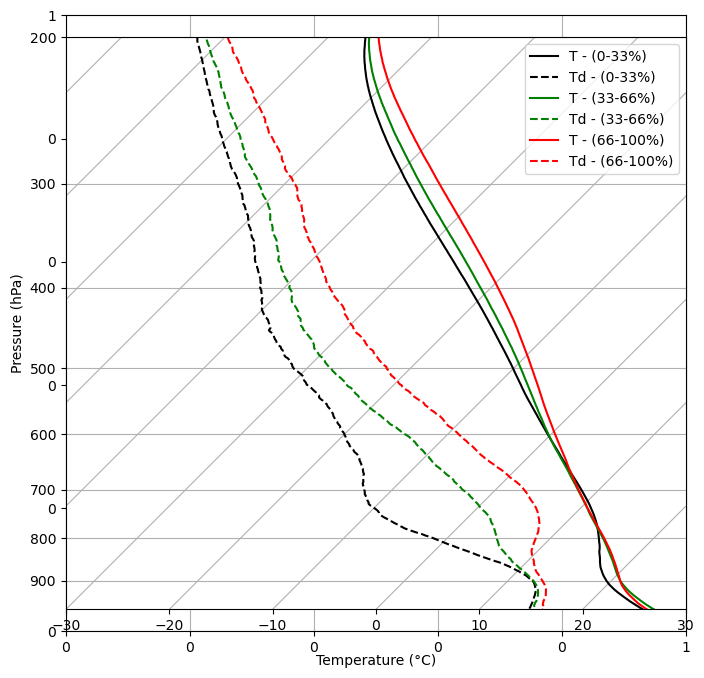

In [22]:
fig, ax = plt.subplots(figsize=(8, 8))

skew = SkewT(fig, rotation=45)

terc_pres = df['interp_pres'][0]

terc_pres = terc_pres[terc_pres <= 1000]

terc_temps = df.groupby('tercile')['interp_temp'].mean().values * units.degC
terc_dps = df.groupby('tercile')['interp_dp'].mean().values * units.degC

colors = ['black', 'green', 'red']

for tercile in range(0, 3):
    lower_bound = tercile * 33
    upper_bound = (tercile + 1) * 33 if tercile < 2 else 100
    label_temp = f'T - ({lower_bound}-{upper_bound}%)'
    label_dp = f'Td - ({lower_bound}-{upper_bound}%)'
    
    skew.plot(terc_pres, terc_temps[tercile], label=label_temp, color=colors[tercile])
    skew.plot(terc_pres, terc_dps[tercile], label=label_dp, linestyle='--', color=colors[tercile])

ax.grid(True)

plt.ylim(975, 200)
plt.xlim(-30, 30)
plt.legend()

# Adding y-label and x-label
plt.ylabel('Pressure (hPa)')

# Adjust the position of the x-axis label
plt.xlabel('Temperature (°C)', labelpad=15)

# Remove duplicate y-axis labels
ax.set_yticklabels([str(int(tick)) for tick in ax.get_yticks()])

# Remove duplicate x-axis labels
ax.set_xticklabels([str(int(tick)) for tick in ax.get_xticks()])

plt.show()


In [23]:
with open('soundings_fig1&4_final.pkl', 'wb') as file:
    
    pickle.dump(df, file)

It is noteworthy that the
temperature and dew point are similar among these three terciles of BLT near the surface (below 900hPa) but clearly
different from above 900 hPa up to at least 400 hPa AGL, which indicates the importance of LT humidity.

For the lower tercile (0% - 33%) of BLT (Figure 4a), dew point values are substantially lower than those for the middle and upper tercile of the BLT (Figures 4b and 4c). The sharp decrease of dew point values with height, near-constant temperature, and large gap between the temperature and dew point profiles at 700-900 hPa suggest strong dry shallow
convection. 

For the middle tercile (Figure 4b), dewpoint and temperature decrease gradually with a height between
900 hPa and 700 hPa, and the gap between the dew point and temperature profiles is smaller than those for the lower
tercile of the BLT (Figure 4a). These features suggest a mixture of dry and moist shallow convection. 

For the upper tercile of BLT (Figure 4c, 67% – 100%), dew point values are nearly constant from the surface to 700 hPa, and the humidity of free troposphere, as indicated by the gap between temperature and dew point profiles, is substantially wetter (implying higher RH) than for the middle and lower tercile of the BLT. These features suggest that moist shallow convection dominates LT. 

Higher dew point values between 700 hPa and 500 hPa also suggest a more humid middle troposphere associated with the upper BLT tercile (Figure 4c) than with the middle and lower BLT tercile (Figure 4a and 4b). Thus, Figure 4 suggests that BLT variations are strongly influenced by the humidity in the lower and middle
troposphere. 